### Carrega as bibliotecas

In [1]:
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/tutorial/graphics-extra.R")

library("daltoolbox")
library("ggplot2")
library("dplyr")
library("reshape")
library("RColorBrewer")
library("corrplot")
library("WVPlots")
library("GGally")
library("aplpack")
library("gridExtra")
library("dbscan")

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘daltoolbox’


The following object is masked from ‘package:base’:

    transform



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


corrplot 0.92 loaded

Loading required package: wrapr


Attaching package: ‘wrapr’


The following object is masked from ‘package:dplyr’:

    coalesce


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
“no DISPLAY variable so Tk is not available”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendro

In [2]:
#Desabilita as Warnings
options(warn = -1)

### Carrega o Dataset

In [3]:
load('/home/data/flight/bfd.RData')

### 1 - Pré-Processamento

#### 1.1 - Seleção de Atributos

In [4]:
#Filtra as colunas para a Clusterização e seleciona somente os voos nacionais

subset <- select(data |> filter(, linetype_code == "N"), "depart_temperature", "depart_wind_speed",
                                                         "arrival_temperature", "arrival_wind_speed",
                                                         "ds_depart_day_period", "ds_arrival_day_period",
                                                         "real_duration")

In [5]:
for (atributo in colnames(subset))
{
    print(atributo)
    print(summary(subset [,atributo]))
    
}

[1] "depart_temperature"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   19.00   24.00   22.73   26.00   40.00 
[1] "depart_wind_speed"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   4.000   6.000   6.417   9.000 109.000 
[1] "arrival_temperature"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    19.0    23.0    22.7    27.0    40.0 
[1] "arrival_wind_speed"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   4.000   6.000   6.365   9.000  69.000 
[1] "ds_depart_day_period"
        Night Early Morning   Mid Morning  Late Morning     Afternoon 
        52795        119948         80146         71394        142831 
Early Evening  Late Evening 
       110035         84611 
[1] "ds_arrival_day_period"
        Night Early Morning   Mid Morning  Late Morning     Afternoon 
        69651         92054         67764         77443        143584 
Early Evening  Late Evening 
       108024        103240 
[1] "real_duration"
   Min. 1st Qu.  Median    Mean 3

#### 1.2 - Remoção de Outliers

In [6]:
#Calcula os limites : outlier threshold alpha = 1.5 -> abaixo de Q1 - 1.5*IQR ou maior que Q3 + 1.5*IQR

boundaries <- fit(outliers(alpha = 1.5), subset)

#Remove os outliers

subset.clean <- transform(boundaries, subset)

#Calcula a quantidade de outliers removidos

idx <- attr(subset.clean, "idx")

noutliers <- as.vector(table(idx)[2])

print(paste("Foram removidos",noutliers,"outliers."))


[1] "Foram removidos 33520 outliers."


#### 1.3 - Verifica os atributos após a remoção de outliers

In [7]:
#Configura as cores e a fonte
colors <- brewer.pal(8, 'Set1')
font <- theme(text = element_text(size=16))

Using  as id variables

Using  as id variables

Using  as id variables

Using  as id variables

Using  as id variables

Using  as id variables

Using  as id variables

Using  as id variables

Using  as id variables

Using  as id variables



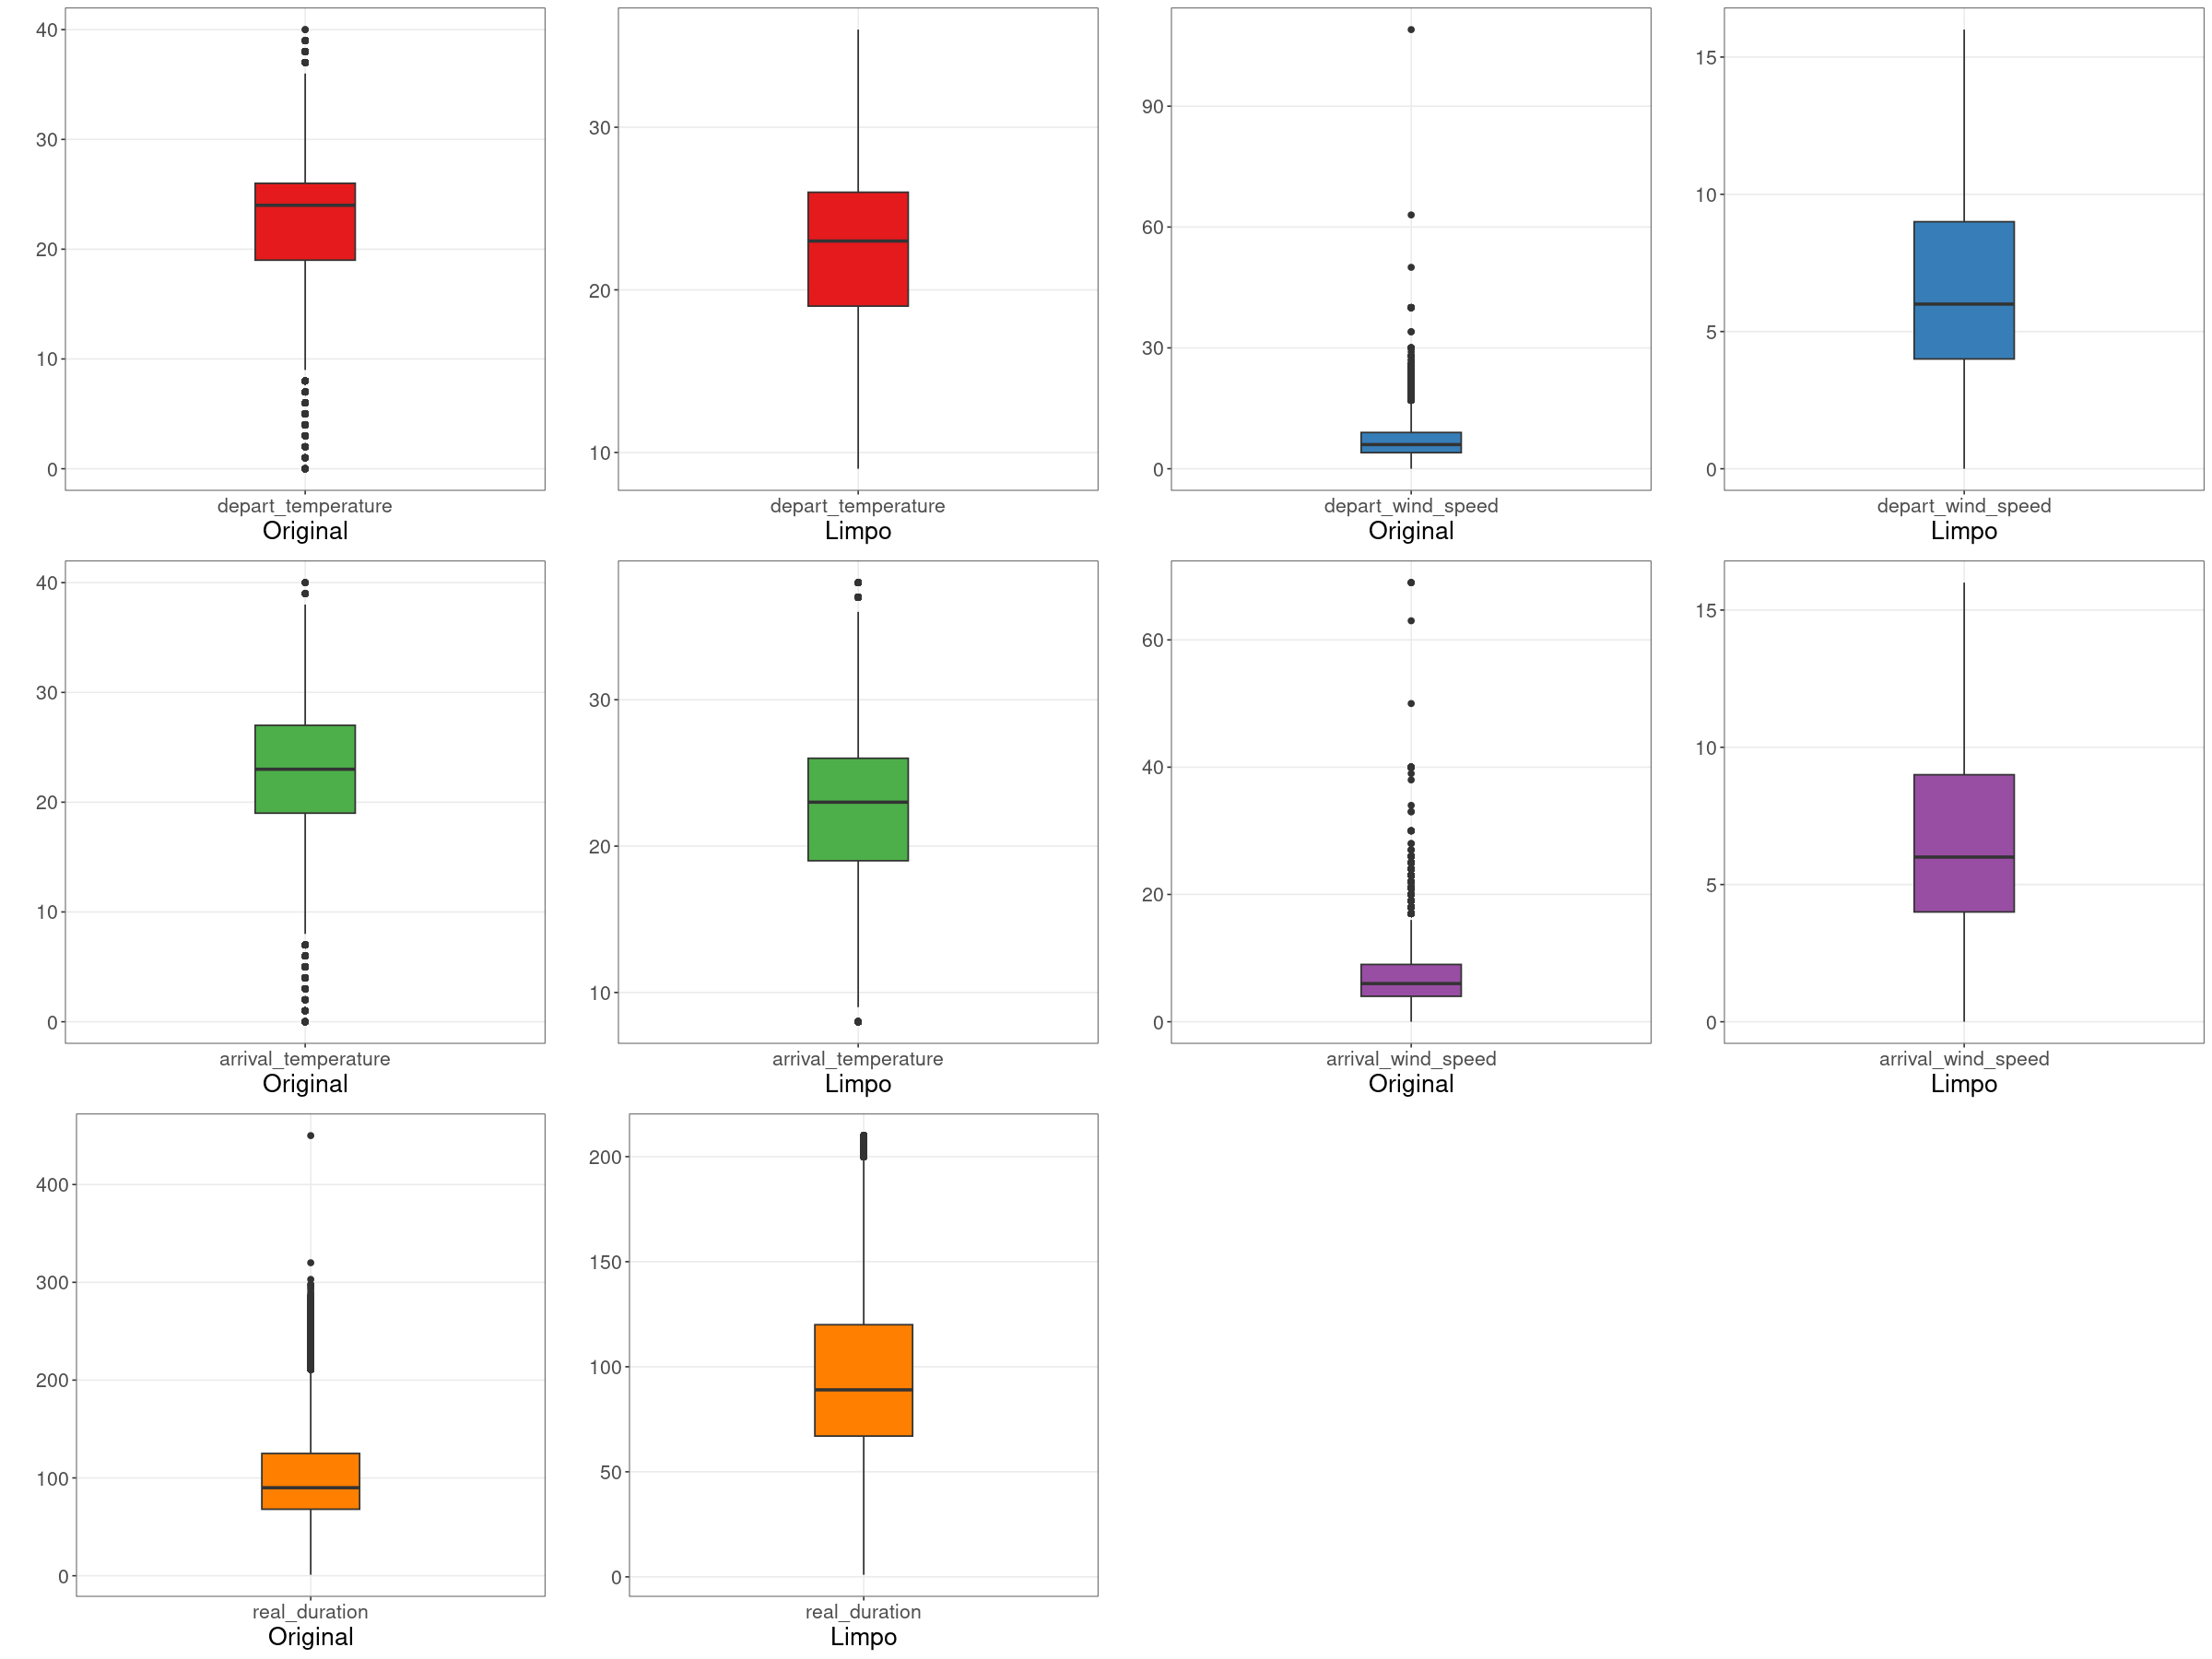

In [8]:
#Imprime os box-plots

box_dt <- plot_boxplot(subset %>% select(depart_temperature), color=colors[1],
                       label_x = "Original") + font

box_dt_clean <- plot_boxplot(subset.clean %>% select(depart_temperature), color=colors[1],
                             label_x = "Limpo") + font

box_dws <- plot_boxplot(subset %>% select(depart_wind_speed), color=colors[2],
                       label_x = "Original") + font

box_dws_clean <- plot_boxplot(subset.clean %>% select(depart_wind_speed), color=colors[2],
                             label_x = "Limpo") + font

box_at <- plot_boxplot(subset %>% select(arrival_temperature), color=colors[3],
                       label_x = "Original") + font

box_at_clean <- plot_boxplot(subset.clean %>% select(arrival_temperature), color=colors[3],
                             label_x = "Limpo") + font

box_aws <- plot_boxplot(subset %>% select(arrival_wind_speed), color=colors[4],
                       label_x = "Original") + font

box_aws_clean <- plot_boxplot(subset.clean %>% select(arrival_wind_speed), color=colors[4],
                             label_x = "Limpo") + font

box_rd <- plot_boxplot(subset %>% select(real_duration), color=colors[5],
                       label_x = "Original") + font

box_rd_clean <- plot_boxplot(subset.clean %>% select(real_duration), color=colors[5],
                             label_x = "Limpo") + font

options(repr.plot.width=20, repr.plot.height=15)
grid.arrange(box_dt, box_dt_clean, box_dws, box_dws_clean, box_at, box_at_clean, box_aws, box_aws_clean, box_rd, box_rd_clean,
             ncol=4)

#### 1.3 - Normaliza os valores contínuos (min-max)

In [9]:
#Faz a normalização minmax dos atributos numéricos do dataset

subset_norm <- transform(fit(minmax(), subset.clean), subset.clean)

#### 1.4 - Faz o mapeamento categórico dos atributos discretizados

In [10]:
#Faz o mapeamento categórico e deriva um novo dataset

subset_cm_ddp <- transform(categ_mapping("ds_depart_day_period"), subset_norm)

subset_cm_adp <- transform(categ_mapping("ds_arrival_day_period"), subset_norm)


final_subset <- select(cbind(subset_norm, subset_cm_ddp, subset_cm_adp),
                           - "ds_depart_day_period", - "ds_arrival_day_period")


In [11]:
#Visualiza o dataset

print(paste("O dataset está com",nrow(final_subset),"tuplas."))
head(final_subset)

[1] "O dataset está com 628240 tuplas."


depart_temperature depart_wind_speed arrival_temperature arrival_wind_speed
1 0.7037037          0.4375            0.5666667           0.125             
2 0.5555556          0.1250            0.4666667           0.125             
3 0.6666667          0.3750            0.4666667           0.125             
4 0.5925926          0.1250            0.4666667           0.125             
5 0.7037037          0.4375            0.4666667           0.125             
6 0.6666667          0.5000            0.4666667           0.125             
  real_duration ds_depart_day_periodNight ds_depart_day_periodEarly Morning
1 0.2392344     1                         0                                
2 0.8803828     1                         0                                
3 0.7129187     1                         0                                
4 0.7894737     1                         0                                
5 0.5693780     1                         0                                
6 0.6889952     1                         0                                
  ds_depart_day_periodMid Morning ds_depart_day_periodLate Morning
1 0                               0                               
2 0                               0                               
3 0                               0                               
4 0                               0                               
5 0                               0                               
6 0                               0                               
  ds_depart_day_periodAfternoon ds_depart_day_periodEarly Evening
1 0                             0                                
2 0                             0                                
3 0                             0                                
4 0                             0                                
5 0                             0                                
6 0                             0                                
  ds_depart_day_periodLate Evening ds_arrival_day_periodNight
1 0                                1                         
2 0                                0                         
3 0                                1                         
4 0                                0                         
5 0                                0                         
6 0                                0                         
  ds_arrival_day_periodEarly Morning ds_arrival_day_periodMid Morning
1 0                                  0                               
2 1                                  0                               
3 0                                  0                               
4 1                                  0                               
5 1                                  0                               
6 1                                  0                               
  ds_arrival_day_periodLate Morning ds_arrival_day_periodAfternoon
1 0                                 0                             
2 0                                 0                             
3 0                                 0                             
4 0                                 0                             
5 0                                 0                             
6 0                                 0                             
  ds_arrival_day_periodEarly Evening ds_arrival_day_periodLate Evening
1 0                                  0                                
2 0                                  0                                
3 0                                  0                                
4 0                                  0                                
5 0                                  0                                
6 0                                  0

## 2 - Clusterização

### 2.1 - Cria uma amostra aleatória do dataset

In [12]:
#Extrai uma amostra aleatória do conjunto de dados

folds <- k_fold(sample_random(), final_subset, 20)

final_subset_fold <- as.data.frame(folds[1])

print(paste("A amostra está com",nrow(final_subset_fold),"tuplas."))

[1] "A amostra está com 31412 tuplas."


### 2.2 - Configura e executa a clusterização

In [15]:
final_subset_sample <- final_subset_fold

# Configura a clusterização
dbscan <- cluster_dbscan(minPts = 2700, eps = .9)
kmeans <- cluster_kmeans(k = 3)
pam <- cluster_pam(k = 3)


# Constrói os modelos
model_dbscan <- fit(dbscan, final_subset_sample)
model_kmeans <- fit(kmeans, final_subset_sample)
model_pam <- fit(pam, final_subset_sample)

clu_dbscan <- cluster(model_dbscan, final_subset_sample)
clu_kmeans <- cluster(model_kmeans, final_subset_sample)
clu_pam <- cluster(model_pam, final_subset_sample)

table(clu_dbscan)
table(clu_kmeans)
table(clu_pam)

final_subset_sample$cluster_dbscan <- factor(clu_dbscan)
final_subset_sample$cluster_dbscan[final_subset_sample$cluster_dbscan == 0] <- NA # O grupo "zero" representa ruído
final_subset_sample$cluster_kmeans <- factor(clu_kmeans)
final_subset_sample$cluster_kmeans[final_subset_sample$cluster_kmeans == 0] <- NA
final_subset_sample$cluster_pam <- factor(clu_pam)
final_subset_sample$cluster_pam[final_subset_sample$cluster_pam == 0] <- NA

#Recupera os "k" de cada método

k_dbscan <- length(unique(clu_dbscan[clu_dbscan != 0]))

k_kmeans <- length(unique(clu_kmeans[clu_kmeans != 0]))

k_pam <- length(unique(clu_pam[clu_pam != 0]))

#Calcula o maior grupo de todos os métodos

ymax <- max(max(table(clu_dbscan)), max(table(clu_kmeans)), max(table(clu_pam)))

clu_dbscan
    0     1     2     3 
21185  4124  3399  2704 

clu_kmeans
    1     2     3 
10647 14058  6707 

clu_pam
    1     2     3 
10877  9237 11298 

## 3 - Interpretação dos resultados

### 3.1 - Gráfico de barras por cluster

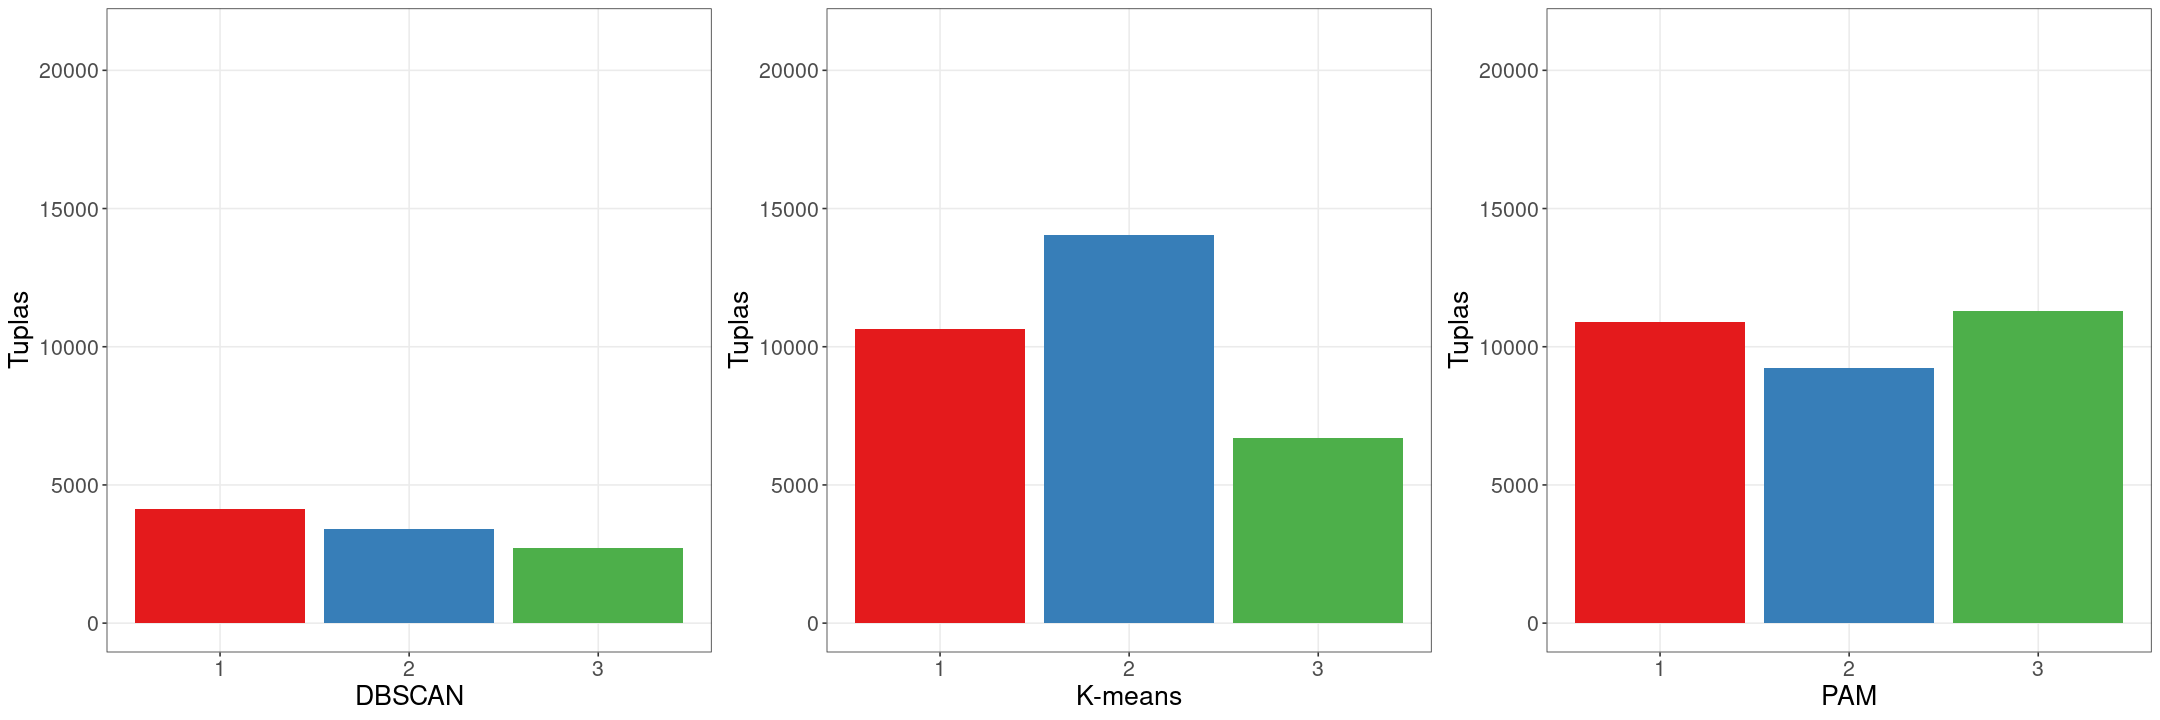

In [16]:
#Plota um gráfico de barras para avaliar as diferentes clusterizações

summarize_dbscan <- final_subset_sample |> dplyr::group_by(cluster_dbscan) |> dplyr::summarize(occurrences=n())
summarize_kmeans <- final_subset_sample |> dplyr::group_by(cluster_kmeans) |> dplyr::summarize(occurrences=n())
summarize_pam <- final_subset_sample |> dplyr::group_by(cluster_pam) |> dplyr::summarize(occurrences=n())


bar_dbscan <- plot_bar(na.omit(summarize_dbscan), label_x = "DBSCAN", label_y = "Tuplas",
                       colors = colors[1:k_dbscan], alpha = 1) + font + scale_y_continuous(limits = c(0, ymax))

bar_kmeans <- plot_bar(na.omit(summarize_kmeans), label_x = "K-means", label_y = "Tuplas",
                       colors = colors[1:k_kmeans], alpha = 1) + font + scale_y_continuous(limits = c(0, ymax))

bar_pam <- plot_bar(na.omit(summarize_pam), label_x = "PAM", label_y = "Tuplas",
                       colors = colors[1:k_pam], alpha = 1) + font + scale_y_continuous(limits = c(0, ymax))

options(repr.plot.width=18, repr.plot.height=6)

grid.arrange(bar_dbscan, bar_kmeans, bar_pam, ncol=3)

### 3.2 - Distribuição de densidade por cluster

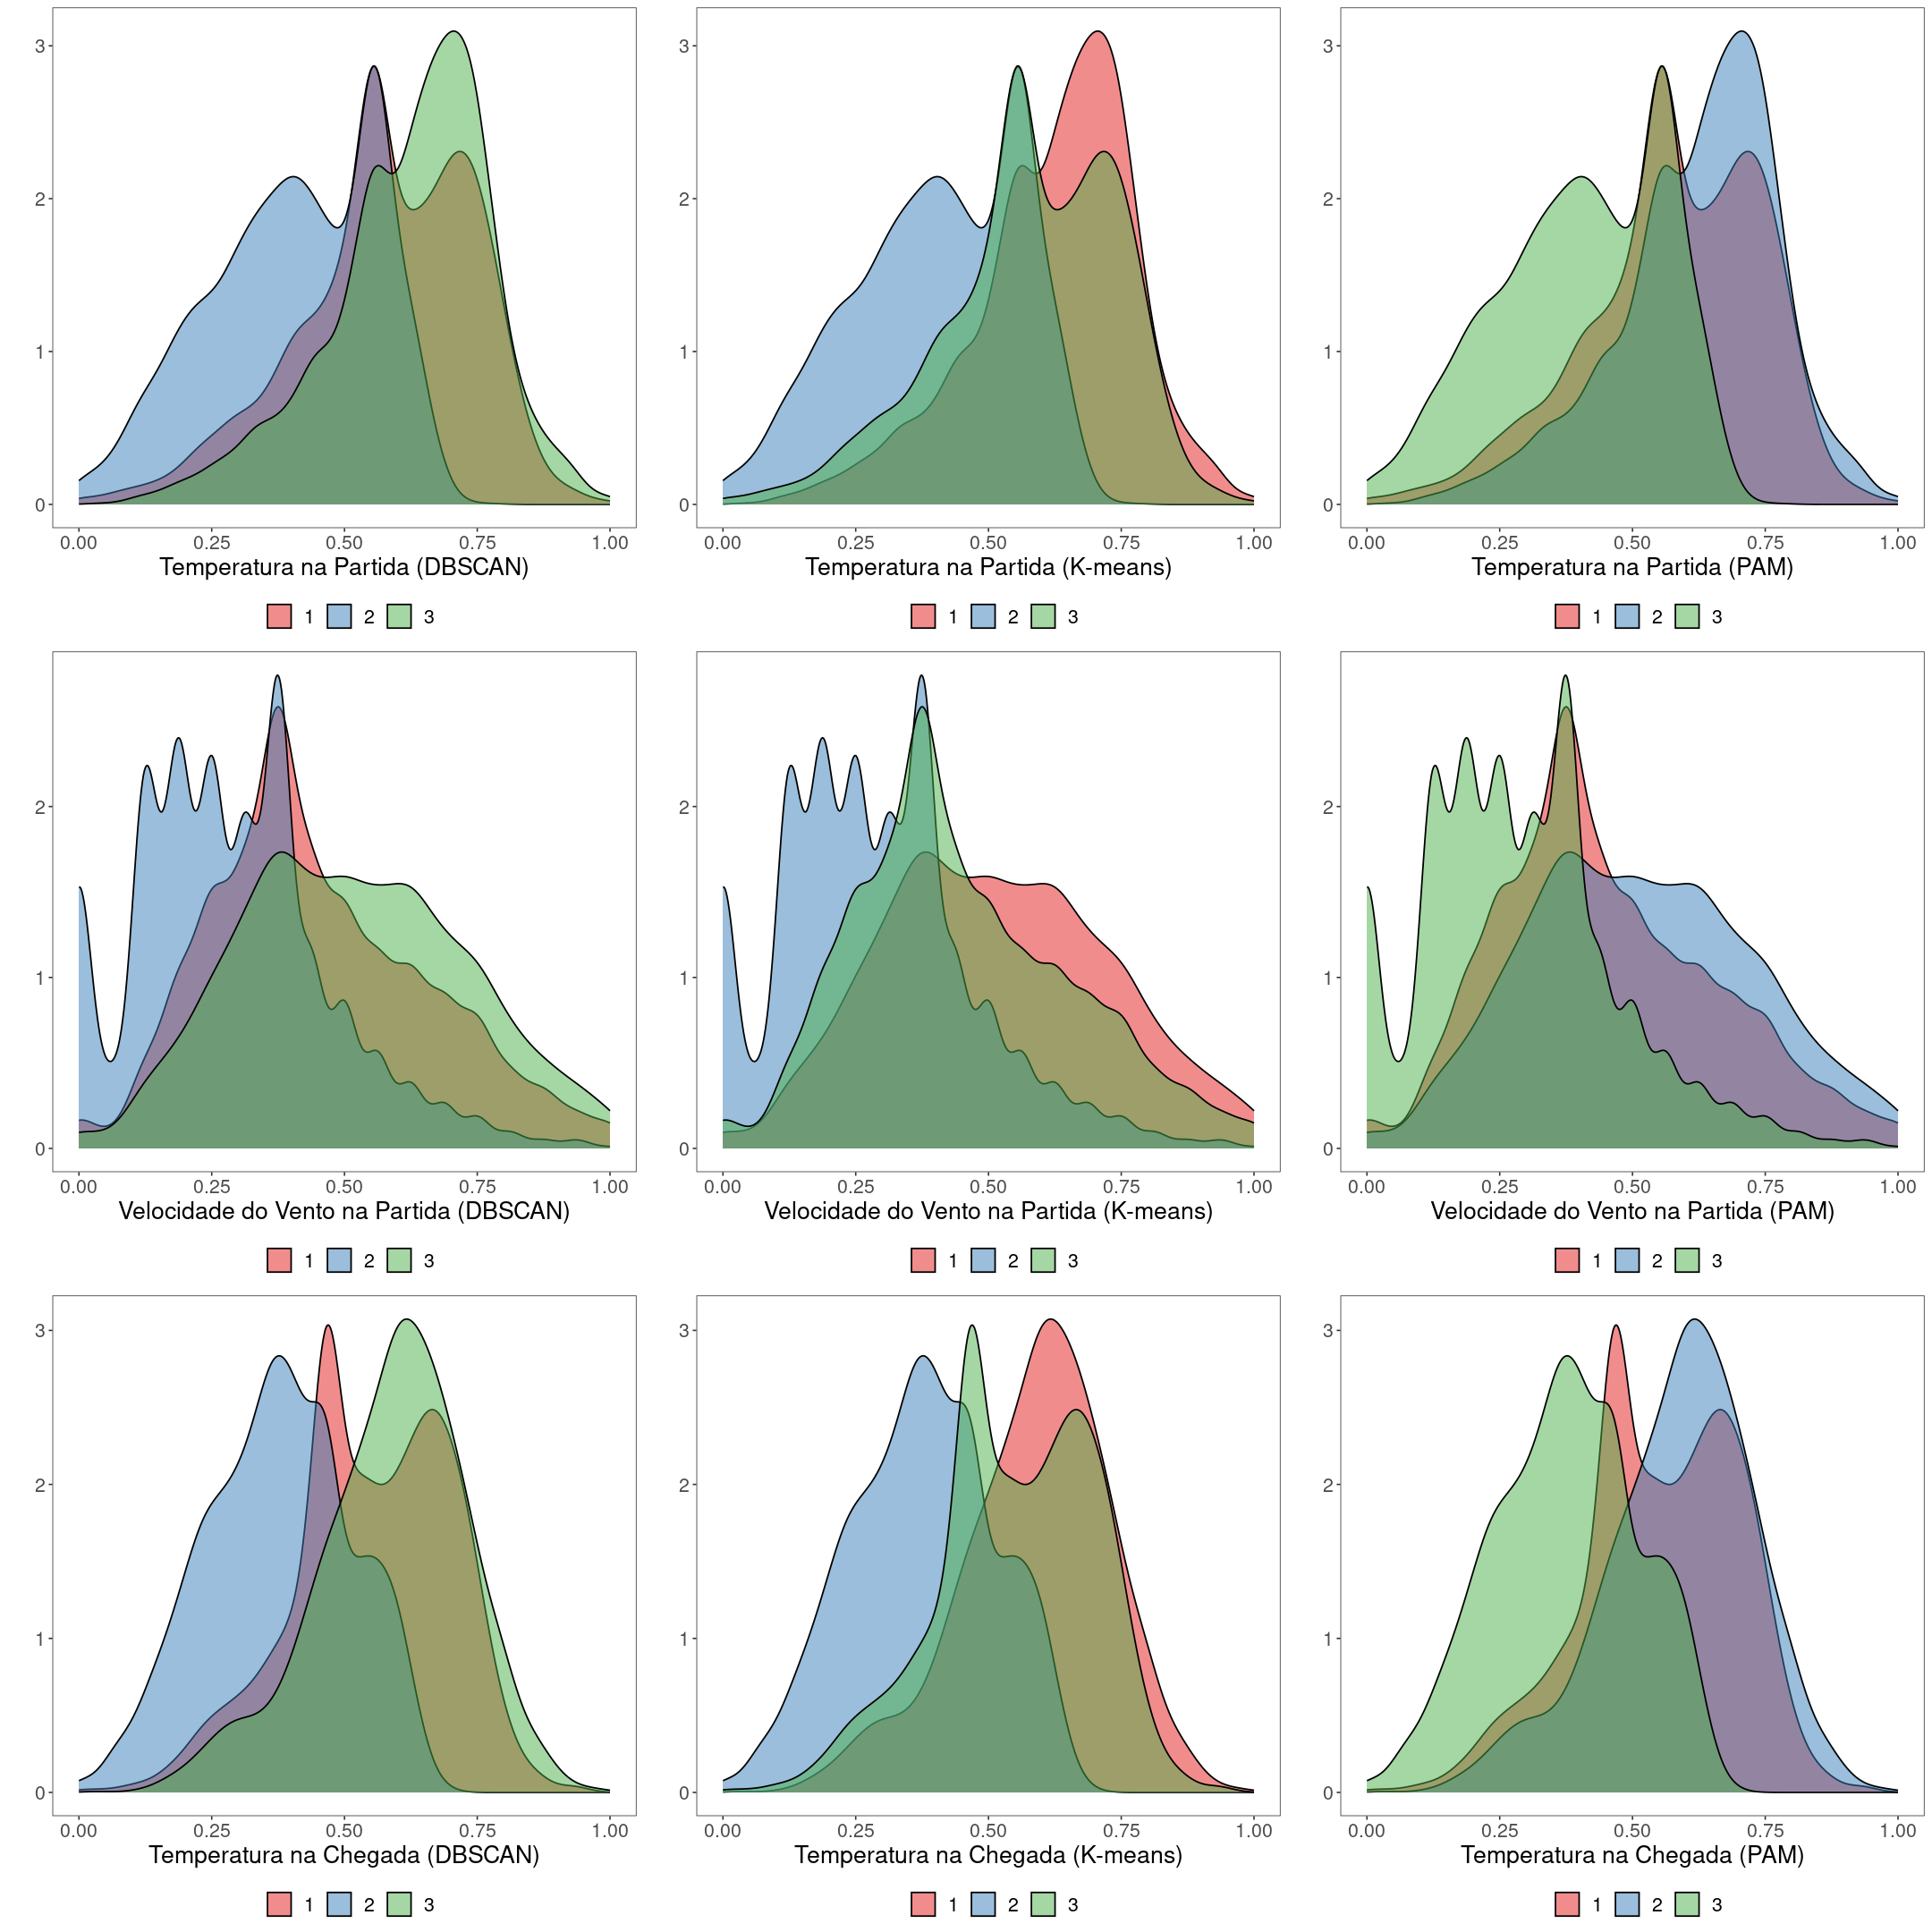

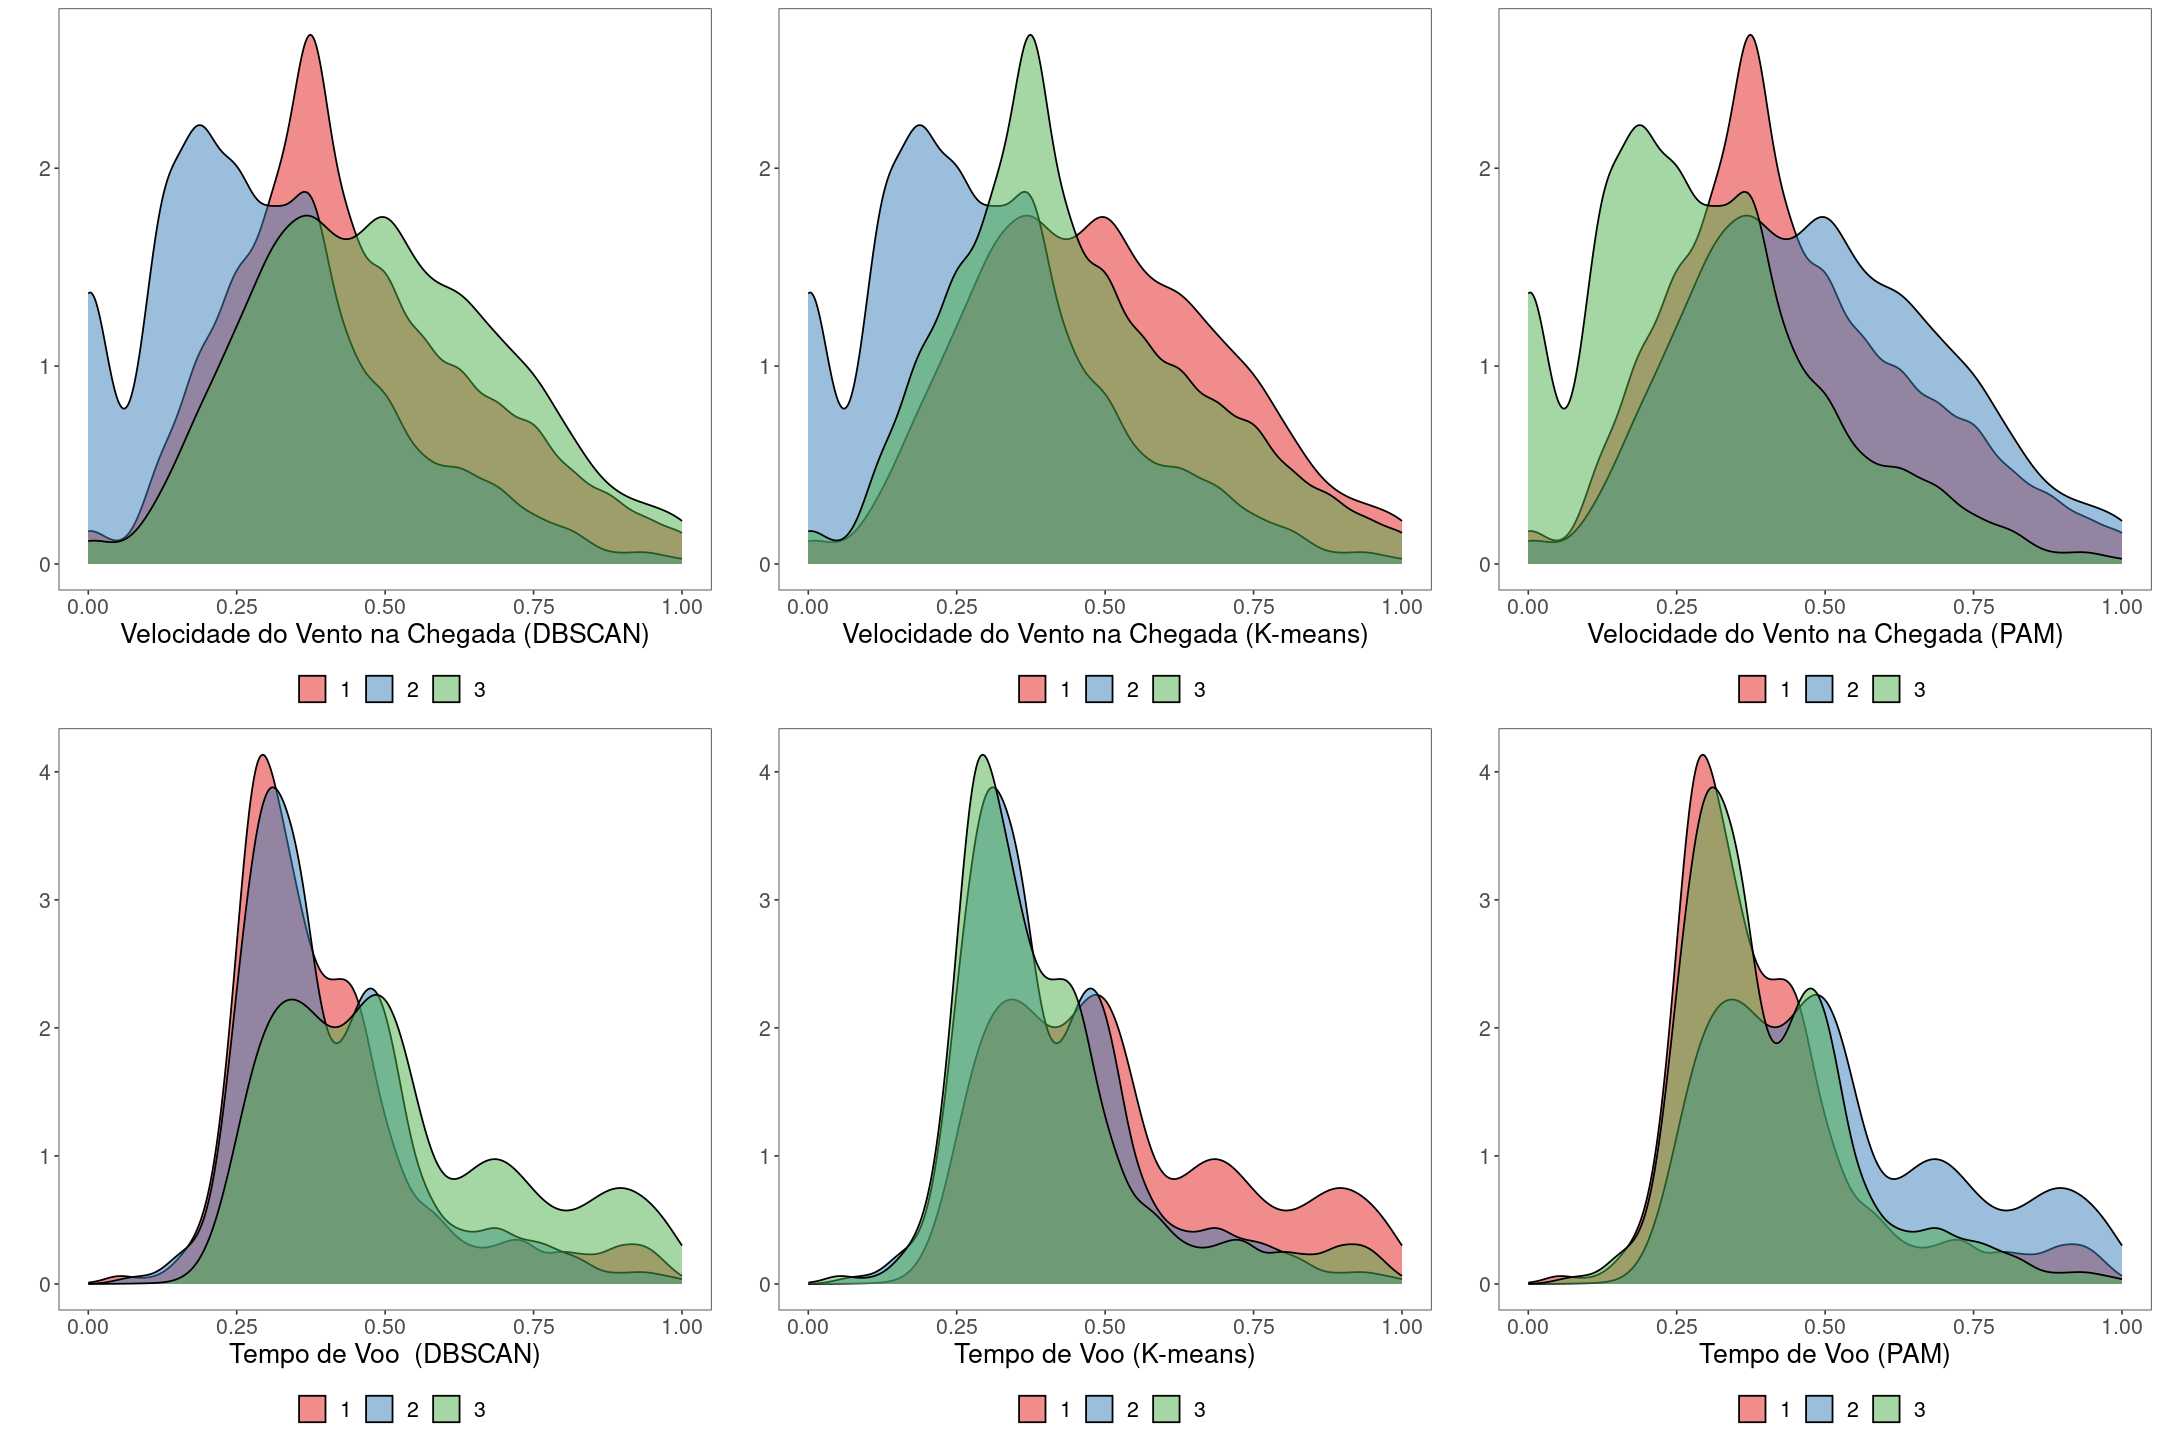

In [17]:
#Distribuição da Temperatura na Partida por cluster

densclass_dt_dbscan <- plot_density_class(na.omit(final_subset_sample)  %>% select(depart_temperature, cluster_dbscan), 
                       class_label="cluster_dbscan",
                       label_x = "Temperatura na Partida (DBSCAN)",
                       color=colors[c(1:k_dbscan)]) + font

densclass_dt_kmeans <- plot_density_class(na.omit(final_subset_sample)  %>% select(depart_temperature, cluster_kmeans), 
                       class_label="cluster_kmeans",
                       label_x = "Temperatura na Partida (K-means)",
                       color=colors[c(1:k_kmeans)]) + font

densclass_dt_pam <- plot_density_class(na.omit(final_subset_sample)  %>% select(depart_temperature, cluster_pam), 
                    class_label="cluster_pam",
                    label_x = "Temperatura na Partida (PAM)",
                    color=colors[c(1:k_pam)]) + font

#Distribuição da Velocidade do Vento na Partida por cluster

densclass_dws_dbscan <- plot_density_class(na.omit(final_subset_sample)  %>% select(depart_wind_speed, cluster_dbscan), 
                       class_label="cluster_dbscan",
                       label_x = "Velocidade do Vento na Partida (DBSCAN)",
                       color=colors[c(1:k_dbscan)]) + font

densclass_dws_kmeans <- plot_density_class(na.omit(final_subset_sample)  %>% select(depart_wind_speed, cluster_kmeans), 
                       class_label="cluster_kmeans",
                       label_x = "Velocidade do Vento na Partida (K-means)",
                       color=colors[c(1:k_kmeans)]) + font

densclass_dws_pam <- plot_density_class(na.omit(final_subset_sample)  %>% select(depart_wind_speed, cluster_pam), 
                    class_label="cluster_pam",
                    label_x = "Velocidade do Vento na Partida (PAM)",
                    color=colors[c(1:k_pam)]) + font

#Distribuição da Temperatura na Chegada por cluster

densclass_at_dbscan <- plot_density_class(na.omit(final_subset_sample)  %>% select(arrival_temperature, cluster_dbscan), 
                       class_label="cluster_dbscan",
                       label_x = "Temperatura na Chegada (DBSCAN)",
                       color=colors[c(1:k_dbscan)]) + font

densclass_at_kmeans <- plot_density_class(na.omit(final_subset_sample)  %>% select(arrival_temperature, cluster_kmeans), 
                       class_label="cluster_kmeans",
                       label_x = "Temperatura na Chegada (K-means)",
                       color=colors[c(1:k_kmeans)]) + font

densclass_at_pam <- plot_density_class(na.omit(final_subset_sample)  %>% select(arrival_temperature, cluster_pam), 
                    class_label="cluster_pam",
                    label_x = "Temperatura na Chegada (PAM)",
                    color=colors[c(1:k_pam)]) + font

#Distribuição da Velocidade do Vento na Chegada por cluster

densclass_aws_dbscan <- plot_density_class(na.omit(final_subset_sample)  %>% select(arrival_wind_speed, cluster_dbscan), 
                       class_label="cluster_dbscan",
                       label_x = "Velocidade do Vento na Chegada (DBSCAN)",
                       color=colors[c(1:k_dbscan)]) + font

densclass_aws_kmeans <- plot_density_class(na.omit(final_subset_sample)  %>% select(arrival_wind_speed, cluster_kmeans), 
                       class_label="cluster_kmeans",
                       label_x = "Velocidade do Vento na Chegada (K-means)",
                       color=colors[c(1:k_kmeans)]) + font

densclass_aws_pam <- plot_density_class(na.omit(final_subset_sample)  %>% select(arrival_wind_speed, cluster_pam), 
                    class_label="cluster_pam",
                    label_x = "Velocidade do Vento na Chegada (PAM)",
                    color=colors[c(1:k_pam)]) + font

#Distribuição do Tempo de Voo por cluster

densclass_rd_dbscan <- plot_density_class(na.omit(final_subset_sample)  %>% select(real_duration, cluster_dbscan), 
                       class_label="cluster_dbscan",
                       label_x = "Tempo de Voo  (DBSCAN)",
                       color=colors[c(1:k_dbscan)]) + font

densclass_rd_kmeans <- plot_density_class(na.omit(final_subset_sample)  %>% select(real_duration, cluster_kmeans), 
                       class_label="cluster_kmeans",
                       label_x = "Tempo de Voo (K-means)",
                       color=colors[c(1:k_kmeans)]) + font

densclass_rd_pam <- plot_density_class(na.omit(final_subset_sample)  %>% select(real_duration, cluster_pam), 
                    class_label="cluster_pam",
                    label_x = "Tempo de Voo (PAM)",
                    color=colors[c(1:k_pam)]) + font




options(repr.plot.width=18, repr.plot.height=18)

grid.arrange(densclass_dt_dbscan, densclass_dt_kmeans, densclass_dt_pam,
             densclass_dws_dbscan, densclass_dws_kmeans, densclass_dws_pam,
             densclass_at_dbscan, densclass_at_kmeans, densclass_at_pam,
             ncol=3)

options(repr.plot.width=18, repr.plot.height=12)

grid.arrange(densclass_aws_dbscan, densclass_aws_kmeans, densclass_aws_pam,
             densclass_rd_dbscan, densclass_rd_kmeans, densclass_rd_pam,
             ncol=3)

### 3.3 - Box-plot por cluster

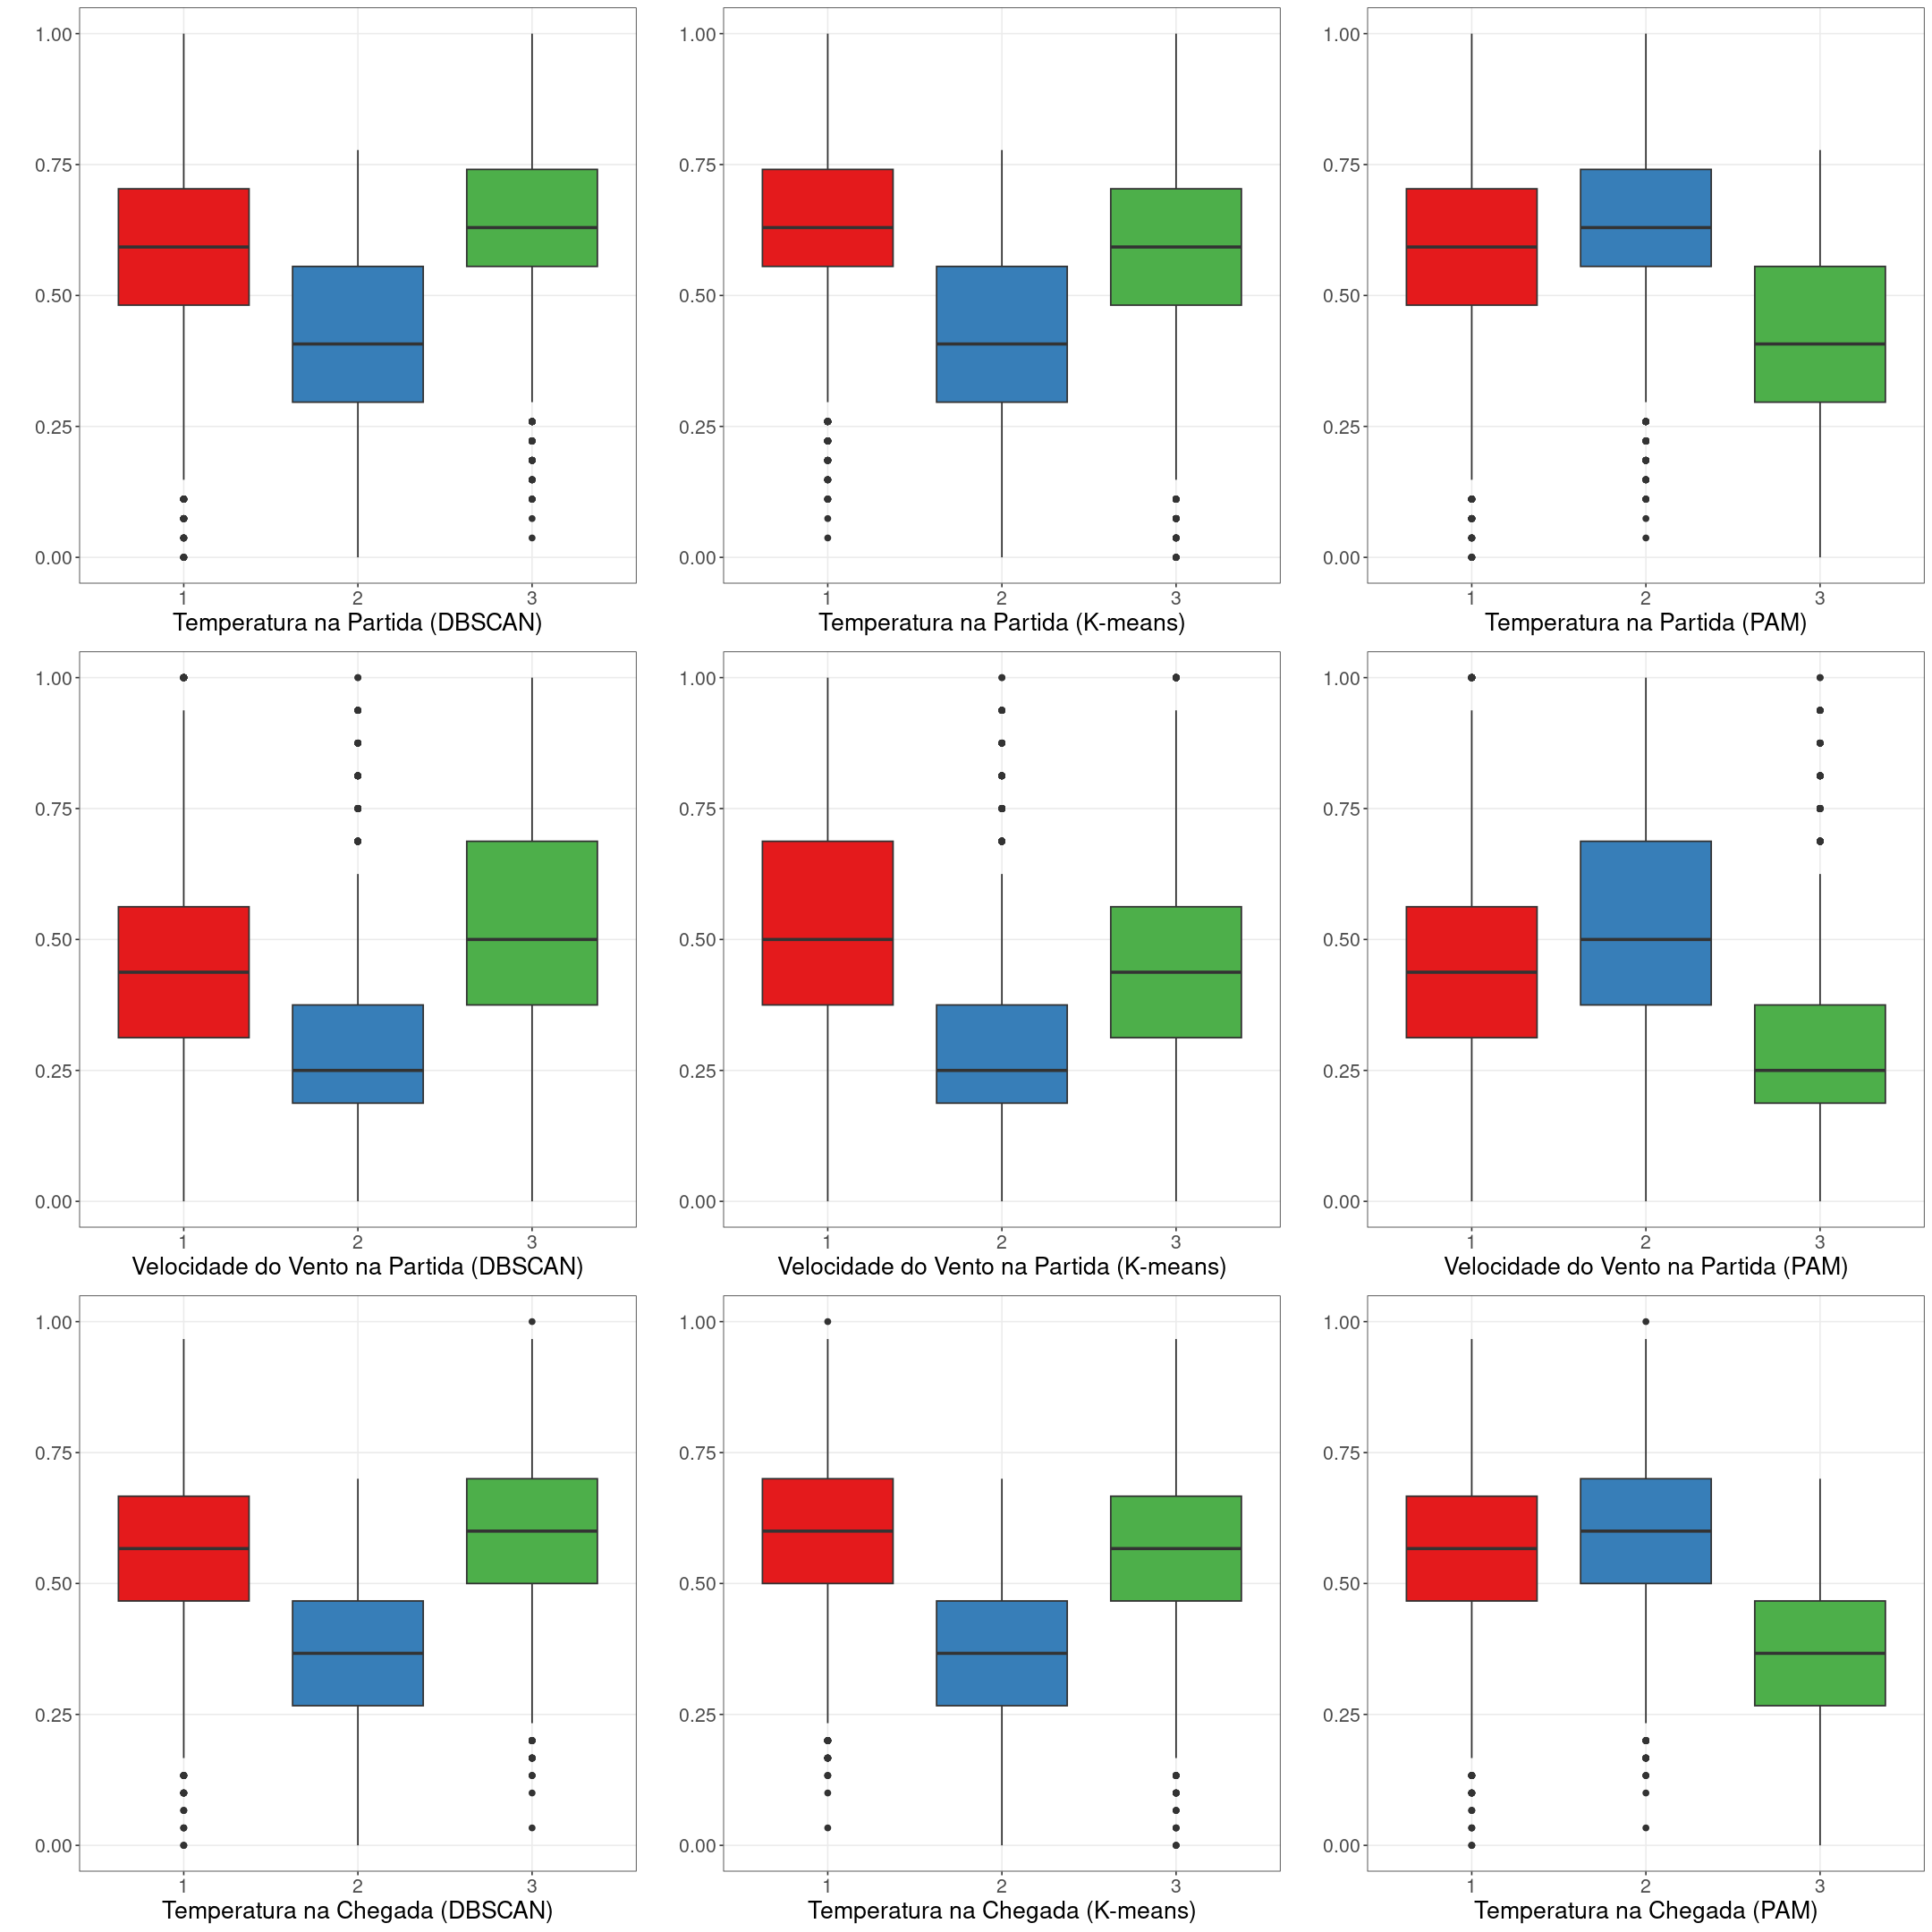

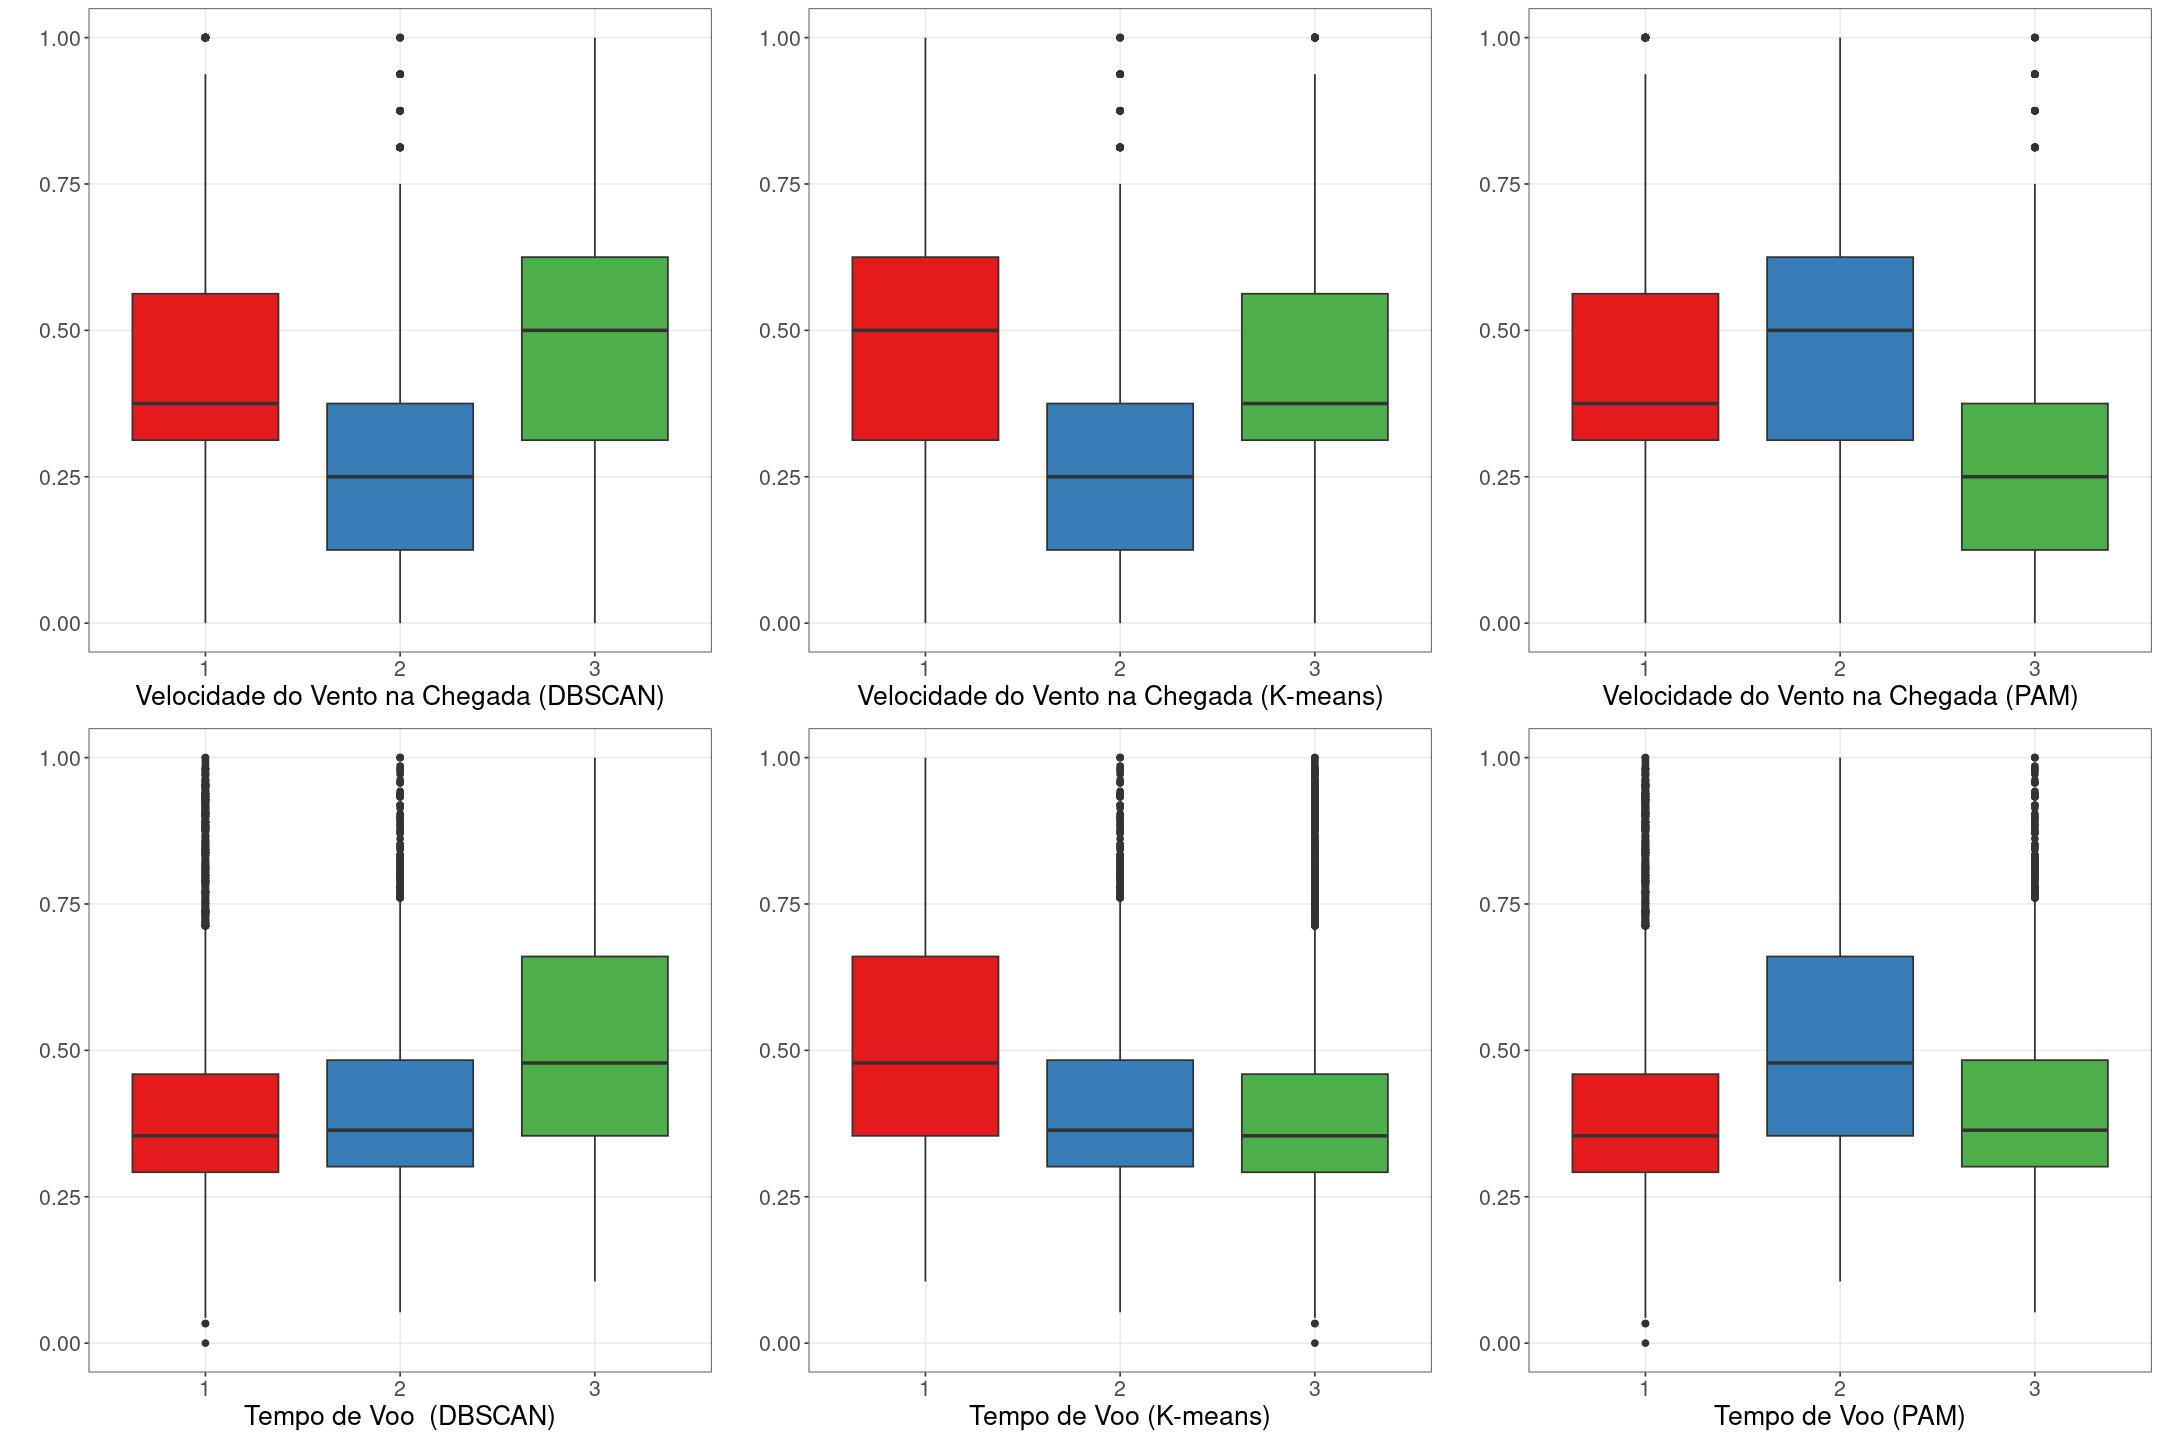

In [18]:
#Distribuição da Temperatura na Partida por cluster

boxclass_dt_dbscan <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(depart_temperature, cluster_dbscan), 
                       class_label="cluster_dbscan",
                       label_x = "Temperatura na Partida (DBSCAN)",
                       color=colors[c(1:k_dbscan)]) + font

boxclass_dt_kmeans <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(depart_temperature, cluster_kmeans), 
                       class_label="cluster_kmeans",
                       label_x = "Temperatura na Partida (K-means)",
                       color=colors[c(1:k_kmeans)]) + font

boxclass_dt_pam <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(depart_temperature, cluster_pam), 
                    class_label="cluster_pam",
                    label_x = "Temperatura na Partida (PAM)",
                    color=colors[c(1:k_pam)]) + font

#Distribuição da Velocidade do Vento na Partida por cluster

boxclass_dws_dbscan <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(depart_wind_speed, cluster_dbscan), 
                       class_label="cluster_dbscan",
                       label_x = "Velocidade do Vento na Partida (DBSCAN)",
                       color=colors[c(1:k_dbscan)]) + font

boxclass_dws_kmeans <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(depart_wind_speed, cluster_kmeans), 
                       class_label="cluster_kmeans",
                       label_x = "Velocidade do Vento na Partida (K-means)",
                       color=colors[c(1:k_kmeans)]) + font

boxclass_dws_pam <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(depart_wind_speed, cluster_pam), 
                    class_label="cluster_pam",
                    label_x = "Velocidade do Vento na Partida (PAM)",
                    color=colors[c(1:k_pam)]) + font

#Distribuição da Temperatura na Chegada por cluster

boxclass_at_dbscan <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(arrival_temperature, cluster_dbscan), 
                       class_label="cluster_dbscan",
                       label_x = "Temperatura na Chegada (DBSCAN)",
                       color=colors[c(1:k_dbscan)]) + font

boxclass_at_kmeans <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(arrival_temperature, cluster_kmeans), 
                       class_label="cluster_kmeans",
                       label_x = "Temperatura na Chegada (K-means)",
                       color=colors[c(1:k_kmeans)]) + font

boxclass_at_pam <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(arrival_temperature, cluster_pam), 
                    class_label="cluster_pam",
                    label_x = "Temperatura na Chegada (PAM)",
                    color=colors[c(1:k_pam)]) + font

#Distribuição da Velocidade do Vento na Chegada por cluster

boxclass_aws_dbscan <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(arrival_wind_speed, cluster_dbscan), 
                       class_label="cluster_dbscan",
                       label_x = "Velocidade do Vento na Chegada (DBSCAN)",
                       color=colors[c(1:k_dbscan)]) + font

boxclass_aws_kmeans <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(arrival_wind_speed, cluster_kmeans), 
                       class_label="cluster_kmeans",
                       label_x = "Velocidade do Vento na Chegada (K-means)",
                       color=colors[c(1:k_kmeans)]) + font

boxclass_aws_pam <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(arrival_wind_speed, cluster_pam), 
                    class_label="cluster_pam",
                    label_x = "Velocidade do Vento na Chegada (PAM)",
                    color=colors[c(1:k_pam)]) + font

#Distribuição do Tempo de Voo por cluster

boxclass_rd_dbscan <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(real_duration, cluster_dbscan), 
                       class_label="cluster_dbscan",
                       label_x = "Tempo de Voo  (DBSCAN)",
                       color=colors[c(1:k_dbscan)]) + font

boxclass_rd_kmeans <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(real_duration, cluster_kmeans), 
                       class_label="cluster_kmeans",
                       label_x = "Tempo de Voo (K-means)",
                       color=colors[c(1:k_kmeans)]) + font

boxclass_rd_pam <- plot_boxplot_class(na.omit(final_subset_sample)  %>% select(real_duration, cluster_pam), 
                    class_label="cluster_pam",
                    label_x = "Tempo de Voo (PAM)",
                    color=colors[c(1:k_pam)]) + font




options(repr.plot.width=18, repr.plot.height=18)

grid.arrange(boxclass_dt_dbscan, boxclass_dt_kmeans, boxclass_dt_pam,
             boxclass_dws_dbscan, boxclass_dws_kmeans, boxclass_dws_pam,
             boxclass_at_dbscan, boxclass_at_kmeans, boxclass_at_pam,
             ncol=3)

options(repr.plot.width=18, repr.plot.height=12)

grid.arrange(boxclass_aws_dbscan, boxclass_aws_kmeans, boxclass_aws_pam,
             boxclass_rd_dbscan, boxclass_rd_kmeans, boxclass_rd_pam,
             ncol=3)

### 3.3 - Matrizes de dispersão avançada

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


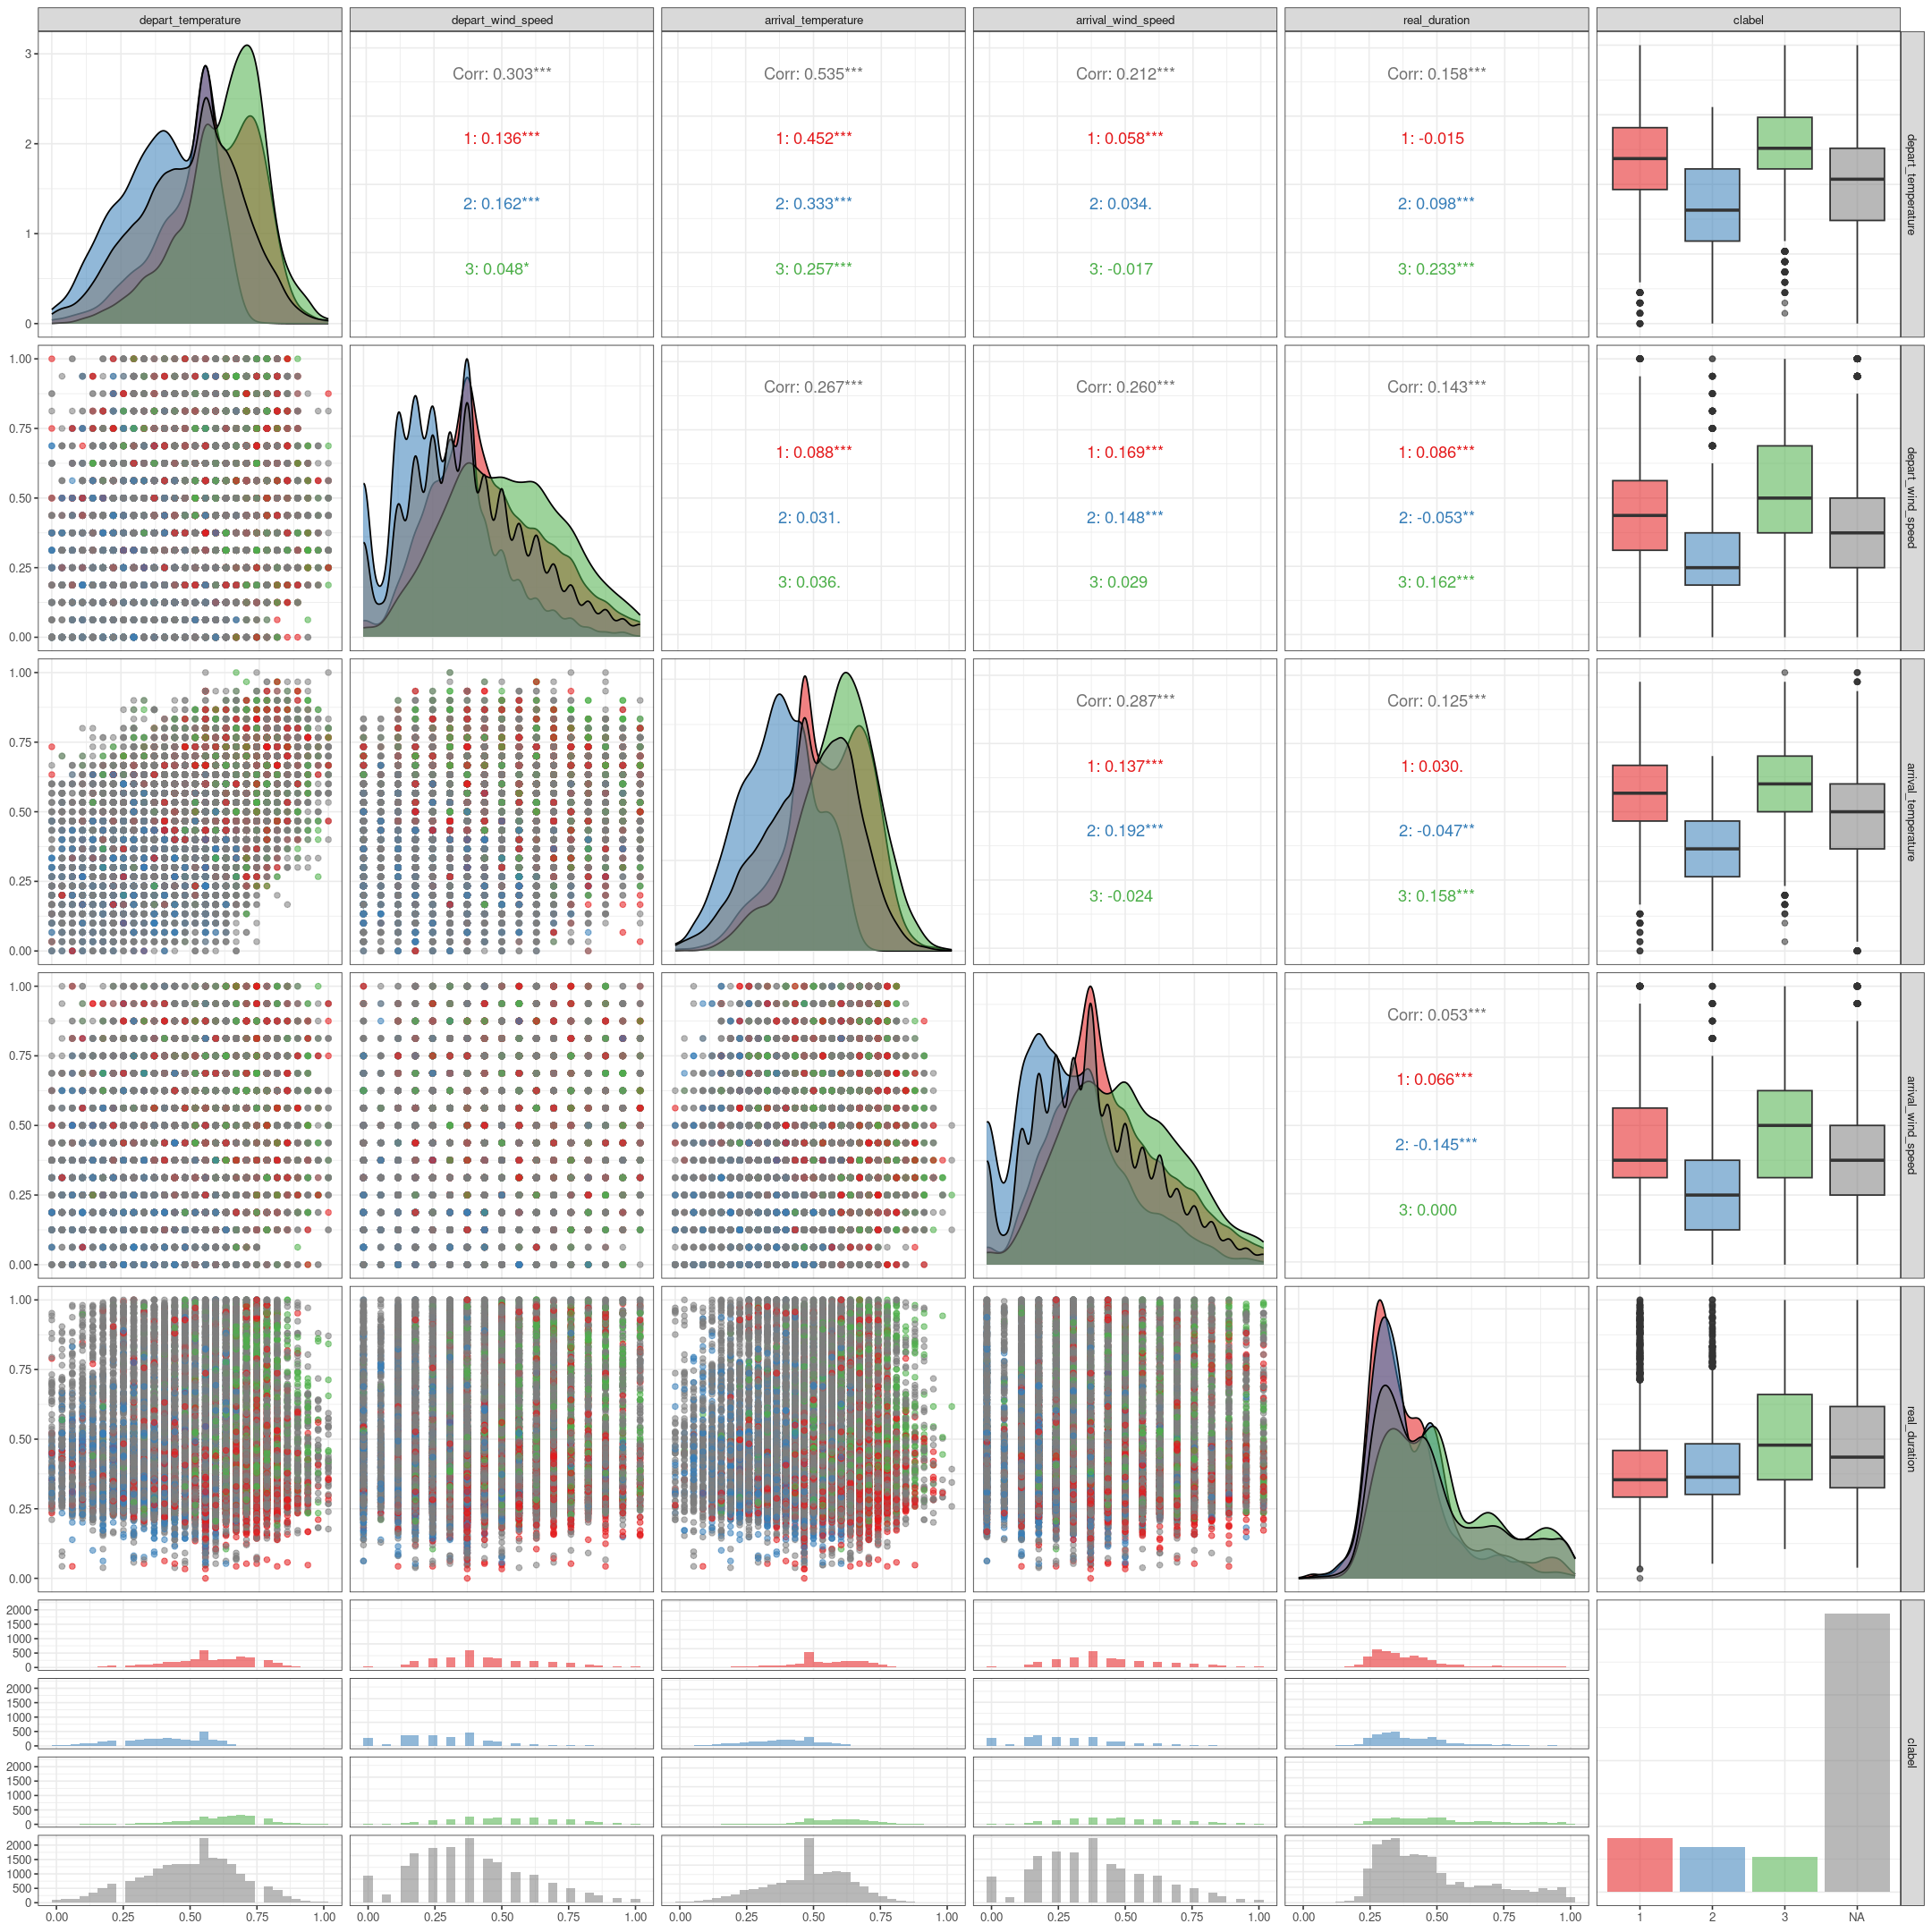

In [19]:
#Matriz de Dispersão Avançada com Classificador (DBSCAN)

pair_adv_dbscan <- plot_pair_adv(data=final_subset_sample, cnames=colnames(final_subset_sample)[1:5], 
                                 title="Aviação DBSCAN", clabel='cluster_dbscan', colors=colors[1:k_dbscan])

options(repr.plot.width=18, repr.plot.height=18)

pair_adv_dbscan

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


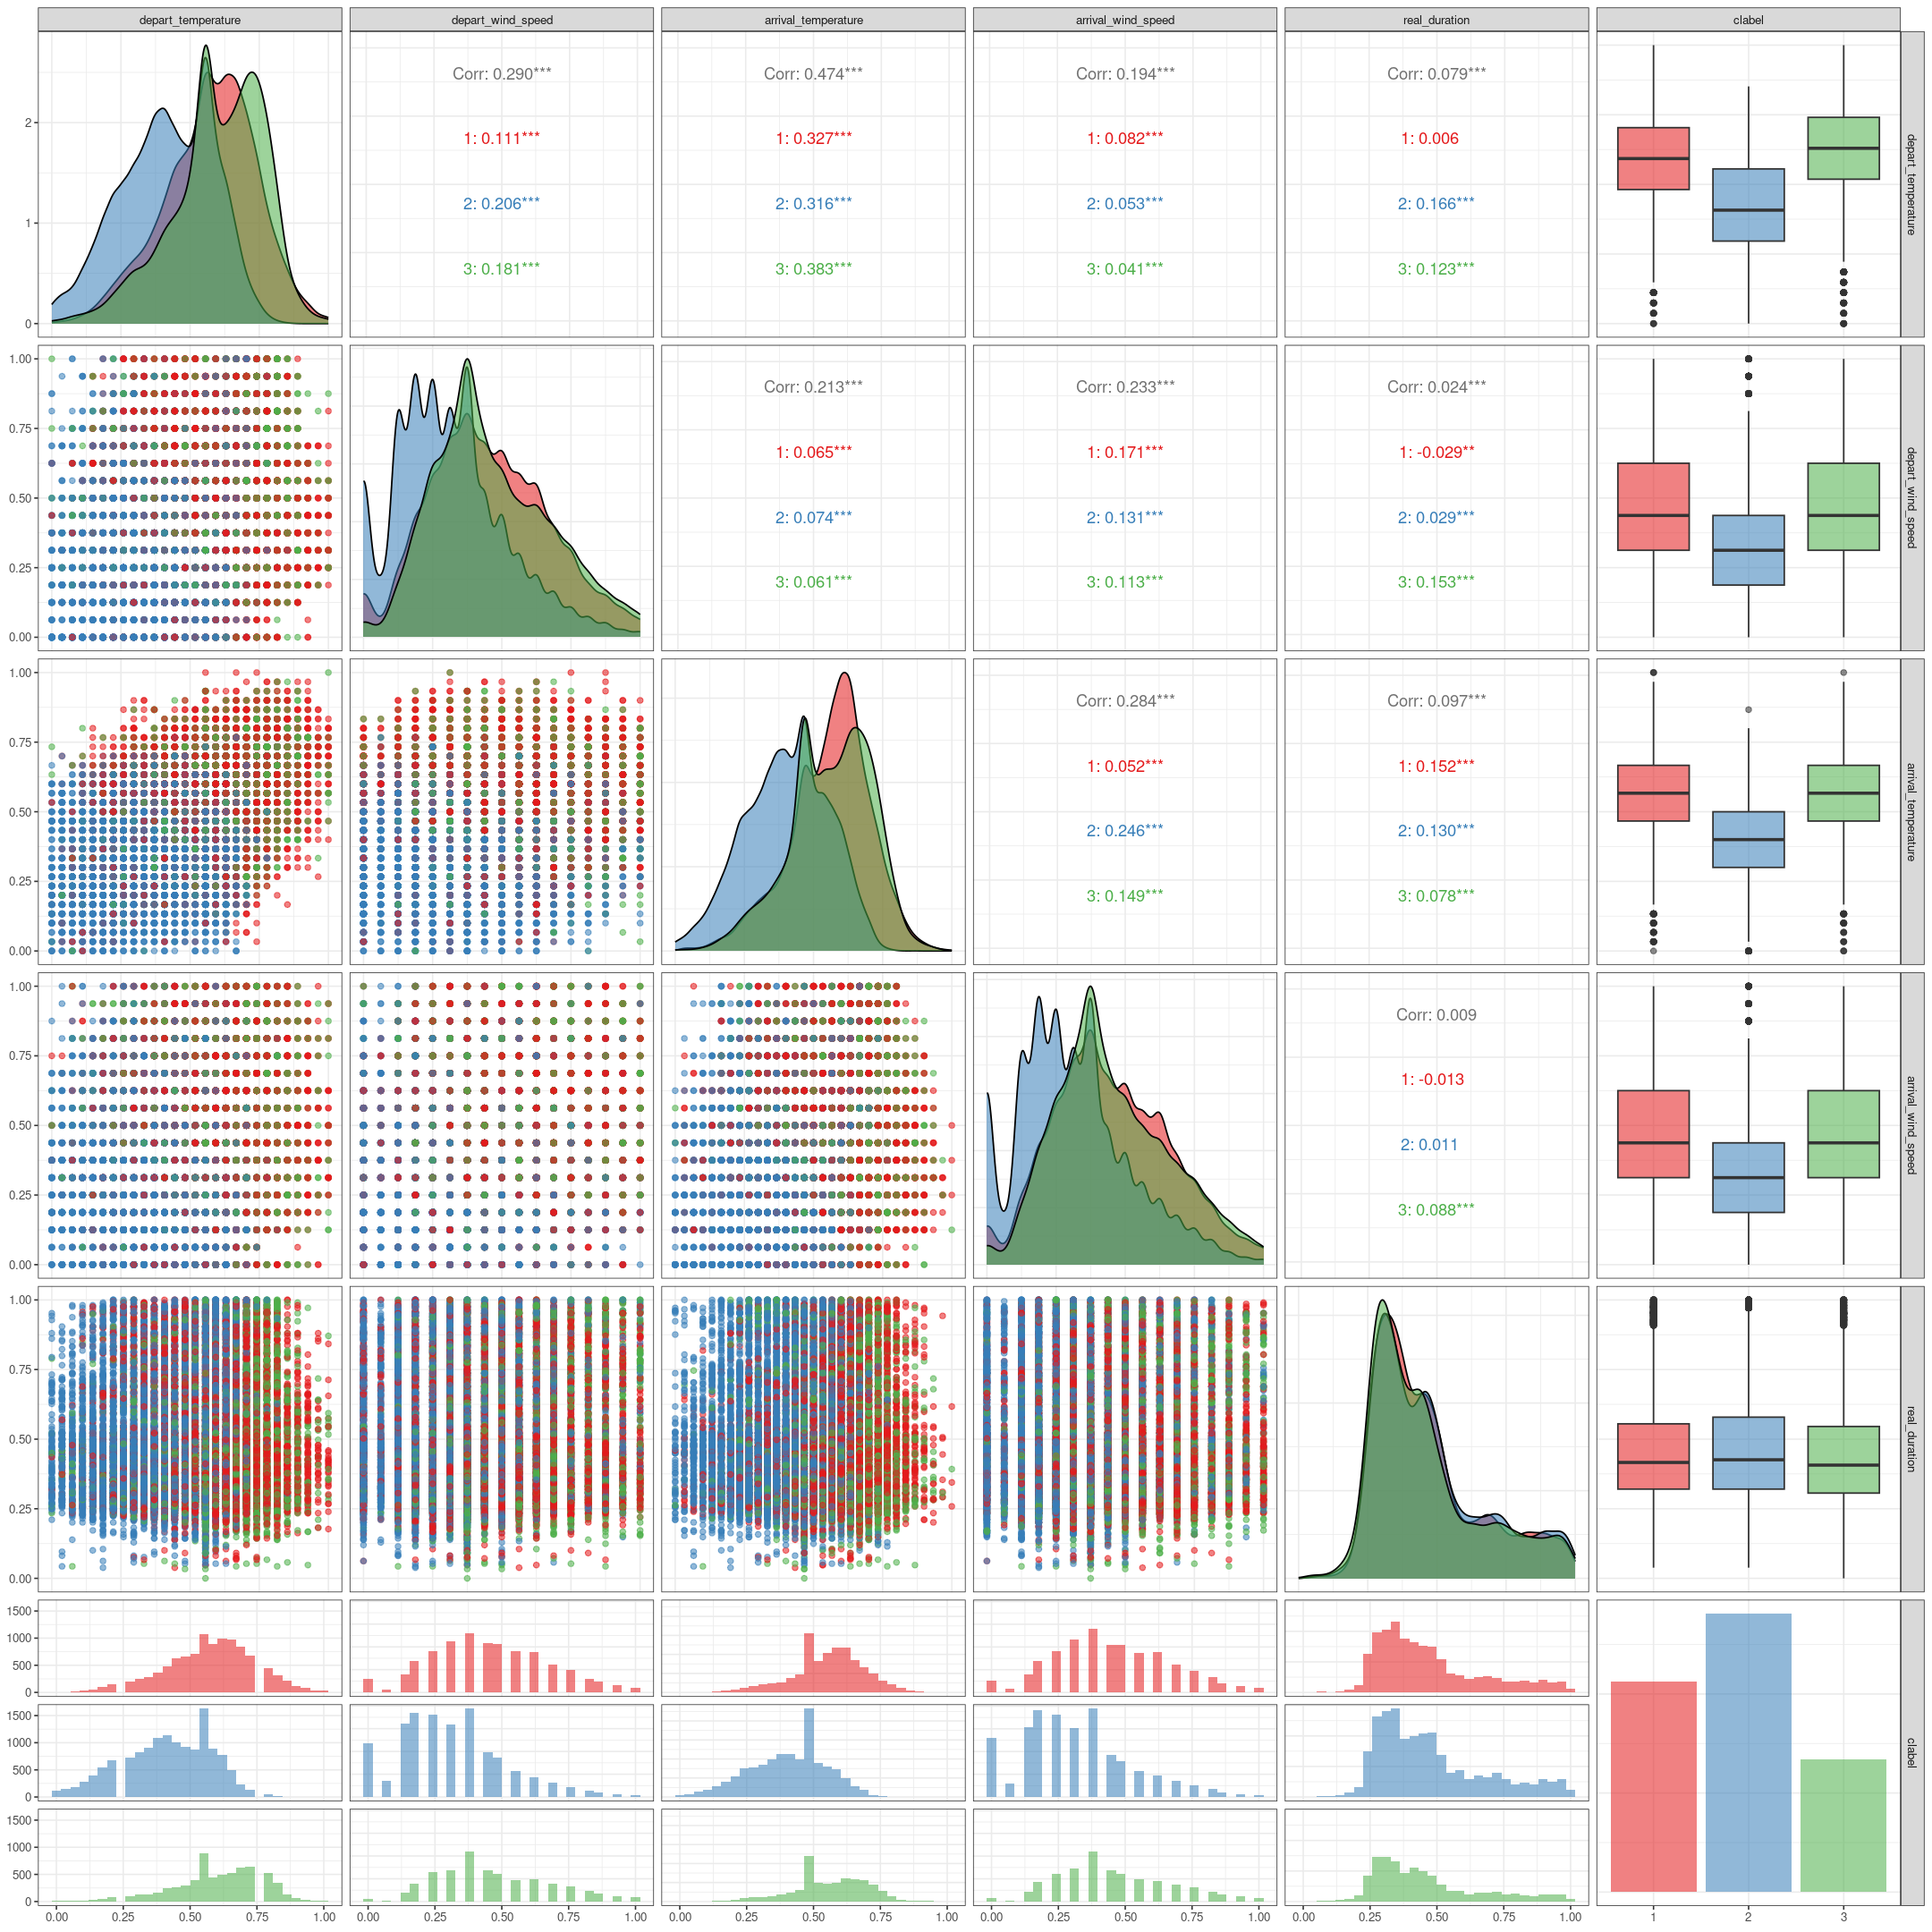

In [20]:
#Matriz de Dispersão Avançada com Classificador (K-means)

pair_adv_kmeans <- plot_pair_adv(data=final_subset_sample, cnames=colnames(final_subset_sample)[1:5], 
                                 title="Aviação KMEANS", clabel='cluster_kmeans', colors=colors[1:k_kmeans])

options(repr.plot.width=18, repr.plot.height=18)

pair_adv_kmeans

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


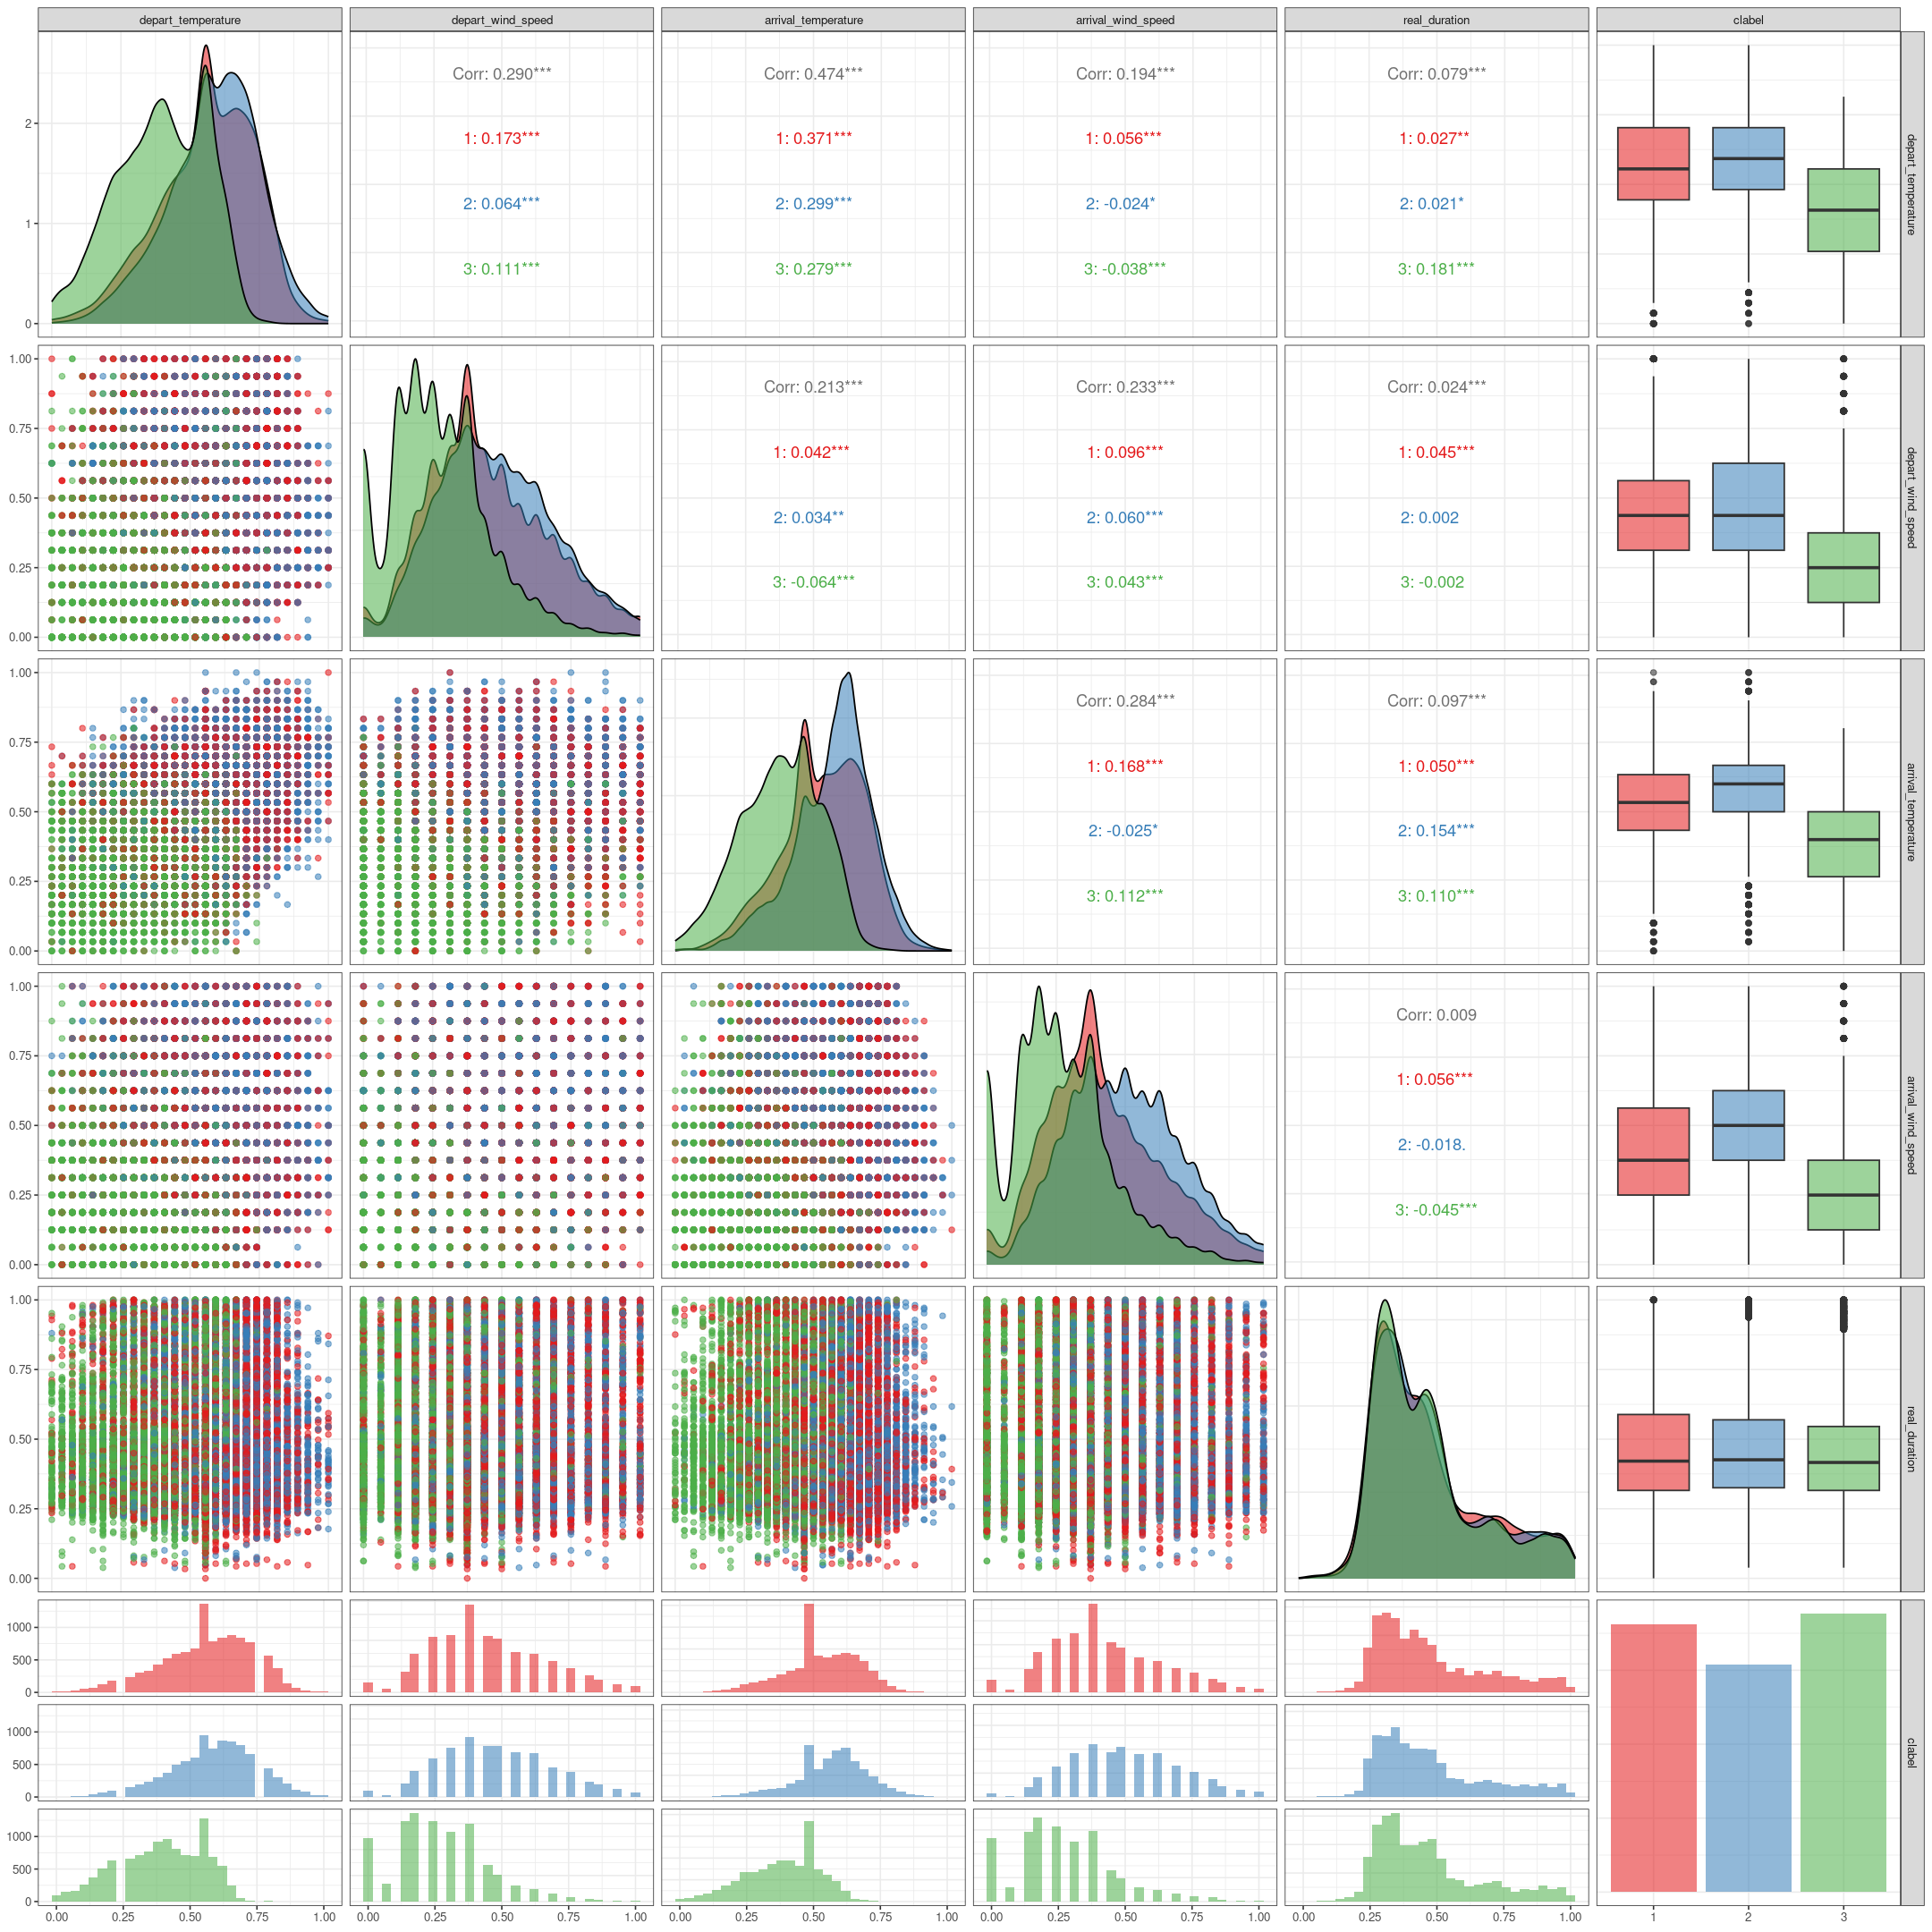

In [21]:
#Matriz de Dispersão Avançada com Classificador (PAM)

pair_adv_pam <- plot_pair_adv(data=final_subset_sample, cnames=colnames(final_subset_sample)[1:5], 
                                 title="Aviação PAM", clabel='cluster_pam', colors=colors[1:k_kmeans])

options(repr.plot.width=18, repr.plot.height=18)

pair_adv_pam